In [11]:
# --- Cell 1: Environment, Paths & API Setup ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ============================================
# 1. PATHS SETUP
# ============================================
try:
    NOTEBOOK_DIR = os.getcwd()
    ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir))
except Exception as e:
    ROOT = "."

DATA_DIR = os.path.join(ROOT, "data")
OUTPUT_DIR = os.path.join(ROOT, "outputs")
CONFIG_DIR = os.path.join(ROOT, "config")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CONFIG_DIR, exist_ok=True)

print(f"ROOT: [{ROOT}]")
print(f"DATA_DIR: [{DATA_DIR}]")
print(f"OUTPUT_DIR: [{OUTPUT_DIR}]")
print(f"CONFIG_DIR: [{CONFIG_DIR}]")

# ============================================
# 2. REFERENCE DATE & SNAPSHOT TIMESTAMP
# ============================================
# Reference: Data current as of Oct 15, 2025
REFERENCE_DATE = datetime(2025, 10, 15)
SNAPSHOT_TIMESTAMP = datetime.now()

print(f"\n[REFERENCE DATE] Strategy data snapshot: {REFERENCE_DATE.strftime('%Y-%m-%d')}")
print(f"[SNAPSHOT TIMESTAMP] Analysis run at: {SNAPSHOT_TIMESTAMP.strftime('%Y-%m-%d %H:%M:%S')}")

# ============================================
# 3. API CREDENTIALS & DATA SOURCES
# ============================================
# Configure API keys (load from environment or .env file if available)
API_KEYS = {
    'ECB': os.getenv('ECB_API_KEY', None),  # European Central Bank (free, no key needed)
    'FRED': os.getenv('FRED_API_KEY', None),  # US Federal Reserve (free, requires key)
    'OECD': os.getenv('OECD_API_KEY', None),  # OECD (free, no key needed)
    'TRADINGVIEW': os.getenv('TRADINGVIEW_API_KEY', None),  # Market data (premium)
    'BLOOMBERG': os.getenv('BLOOMBERG_API_KEY', None),  # Bloomberg (premium)
}

DATA_SOURCES = {
    'public_debt': ['Fitch', 'Banque de France', 'OECD'],
    'deficit': ['Eurostat', 'Banque de France', 'OECD'],
    'inflation': ['Eurostat', 'Banque de France'],
    'gdp_growth': ['Eurostat', 'OECD', 'Banque de France'],
    'unemployment': ['Eurostat', 'OECD'],
    'yields_spreads': ['ECB', 'TradingView', 'Reuters'],
    'cds': ['CDS Pricing Services', 'TradingView'],
    'ratings': ['Fitch', 'S&P', 'Moody\'s'],
}

print("\n[DATA SOURCES CONFIGURED]")
for metric, sources in DATA_SOURCES.items():
    print(f"  {metric}: {', '.join(sources)}")

# ============================================
# 4. FALLBACK DATA (Latest as of Oct 15, 2025)
# ============================================
FALLBACK_DATA = {
    'public_debt_pct_gdp': 114.0,  # 2024 estimate
    'deficit_pct_gdp': 5.8,  # 2024 estimate
    'inflation_headline': 1.0,  # 2025 forecast
    'inflation_core': 1.9,  # 2026 forecast
    'gdp_growth': 0.6,  # 2025 forecast
    'unemployment_rate': 7.9,  # 2025 expected
    'oat_5y_yield': 2.8,  # %
    'oat_10y_yield': 3.47,  # %
    'bund_10y_yield': 2.67,  # % (approx)
    'france_bund_spread_bps': 80,  # basis points
    'cds_5y_bps': 36,  # basis points
    'fitch_rating': 'A+',  # Latest downgrade
    'fitch_outlook': 'Stable',
}

print("\n[FALLBACK DATA INITIALIZED] (as of Oct 15, 2025)")
print(f"  Public Debt: {FALLBACK_DATA['public_debt_pct_gdp']}% GDP")
print(f"  Deficit: {FALLBACK_DATA['deficit_pct_gdp']}% GDP")
print(f"  10Y OAT Yield: {FALLBACK_DATA['oat_10y_yield']}%")
print(f"  France-Bund Spread: {FALLBACK_DATA['france_bund_spread_bps']} bps")
print(f"  CDS 5Y: {FALLBACK_DATA['cds_5y_bps']} bps")

# ============================================
# 5. UTILITY FUNCTIONS
# ============================================
def load_or_fetch_data(metric_name, use_fallback=True):
    """
    Attempt to fetch live data; fall back to FALLBACK_DATA if unavailable.
    Returns tuple: (value, source, timestamp)
    """
    try:
        # Try to load from local CSV cache first
        cache_file = os.path.join(DATA_DIR, f"{metric_name}.csv")
        if os.path.exists(cache_file):
            df = pd.read_csv(cache_file)
            latest = df.iloc[-1]
            return latest['value'], 'cached', latest.get('timestamp', REFERENCE_DATE.isoformat())
    except Exception as e:
        pass
    
    # If fallback enabled, return static value
    if use_fallback and metric_name in FALLBACK_DATA:
        return FALLBACK_DATA[metric_name], 'fallback', REFERENCE_DATE.isoformat()
    
    return None, 'unavailable', None

def save_data_snapshot(df, metric_name):
    """Save metric data snapshot to CSV."""
    try:
        output_file = os.path.join(DATA_DIR, f"{metric_name}.csv")
        df.to_csv(output_file, index=False)
        print(f"  ✓ Saved: {metric_name}")
    except Exception as e:
        print(f"  ✗ Error saving {metric_name}: {e}")

print("\n[UTILITIES READY] load_or_fetch_data(), save_data_snapshot()")
print("\n" + "="*60)
print("Cell 1 COMPLETE: Environment, paths, APIs, and data ready.")
print("="*60)

ROOT: [c:\Users\HP\Desktop\projects\Trojan_Horse_France]
DATA_DIR: [c:\Users\HP\Desktop\projects\Trojan_Horse_France\data]
OUTPUT_DIR: [c:\Users\HP\Desktop\projects\Trojan_Horse_France\outputs]
CONFIG_DIR: [c:\Users\HP\Desktop\projects\Trojan_Horse_France\config]

[REFERENCE DATE] Strategy data snapshot: 2025-10-15
[SNAPSHOT TIMESTAMP] Analysis run at: 2025-10-18 11:28:02

[DATA SOURCES CONFIGURED]
  public_debt: Fitch, Banque de France, OECD
  deficit: Eurostat, Banque de France, OECD
  inflation: Eurostat, Banque de France
  gdp_growth: Eurostat, OECD, Banque de France
  unemployment: Eurostat, OECD
  yields_spreads: ECB, TradingView, Reuters
  cds: CDS Pricing Services, TradingView
  ratings: Fitch, S&P, Moody's

[FALLBACK DATA INITIALIZED] (as of Oct 15, 2025)
  Public Debt: 114.0% GDP
  Deficit: 5.8% GDP
  10Y OAT Yield: 3.47%
  France-Bund Spread: 80 bps
  CDS 5Y: 36 bps

[UTILITIES READY] load_or_fetch_data(), save_data_snapshot()

Cell 1 COMPLETE: Environment, paths, APIs, and 

In [12]:
# --- Cell 2: Fetch France 10Y OAT & German 10Y Bund Yields ---
import pandas as pd
import numpy as np
import os
import requests
from datetime import datetime, timedelta
import json

DATA_DIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data")
os.makedirs(DATA_DIR, exist_ok=True)

print("="*70)
print("CELL 2: FETCH FRANCE 10Y OAT & BUND YIELDS (FREE APIs)")
print("="*70)

# ============================================
# STRATEGY: Try multiple free APIs in sequence
# ============================================
# 1. FRED (Federal Reserve, free but US-focused)
# 2. Eurostat (EU central, authoritative, slow)
# 3. Yahoo Finance (yfinance, fastest but limited)
# 4. Fallback: hardcoded baseline from Cell 1

FRED_API_KEY = os.getenv('FRED_API_KEY', 'YOUR_FRED_KEY_HERE')
REFERENCE_DATE = datetime(2025, 10, 15)
FALLBACK_10Y_OAT = 3.47
FALLBACK_10Y_BUND = 2.67

# ============================================
# METHOD 1: Try FRED (if you have API key)
# ============================================
def fetch_fred_data(series_id, api_key=FRED_API_KEY):
    """Fetch from FRED (US Federal Reserve); works for EUR yields."""
    try:
        url = f"https://api.stlouisfed.org/fred/series/observations"
        params = {
            'series_id': series_id,
            'api_key': api_key,
            'file_type': 'json',
            'sort_order': 'desc',
            'limit': 500
        }
        resp = requests.get(url, params=params, timeout=10)
        if resp.status_code == 200:
            data = resp.json()
            if 'observations' in data:
                obs = sorted(data['observations'], key=lambda x: x['date'])
                df = pd.DataFrame(obs)
                df['date'] = pd.to_datetime(df['date'])
                df['value'] = pd.to_numeric(df['value'], errors='coerce')
                df = df.dropna(subset=['value'])
                return df[['date', 'value']].copy()
    except Exception as e:
        print(f"  ⚠️ FRED fetch failed: {e}")
    return None

# ============================================
# METHOD 2: Try yfinance (fastest, reliable)
# ============================================
def fetch_yfinance_yield(ticker_str, name, start_date="2015-01-01"):
    """Fetch yield data from yfinance (best-effort)."""
    try:
        import yfinance as yf
        print(f"  📡 Fetching {name} from yfinance ({ticker_str})...")
        tick = yf.Ticker(ticker_str)
        hist = tick.history(start=start_date)
        if not hist.empty and 'Close' in hist.columns:
            df = hist[['Close']].reset_index()
            df.rename(columns={'Date': 'date', 'Close': 'value'}, inplace=True)
            df['value'] = pd.to_numeric(df['value'], errors='coerce')
            df = df.dropna()
            print(f"    ✅ Got {len(df)} observations")
            return df
    except Exception as e:
        print(f"  ⚠️ yfinance fetch for {name} failed: {e}")
    return None

# ============================================
# METHOD 3: Eurostat (slow but authoritative)
# ============================================
def fetch_eurostat_yield(country_code, maturity, start_year=2015):
    """
    Fetch from Eurostat REST API (EU gov bond yields).
    country_code: 'FR' for France, 'DE' for Germany
    maturity: 10 (for 10-year)
    """
    try:
        print(f"  📡 Querying Eurostat for {country_code} {maturity}Y yield...")
        base_url = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data"
        dataset = "irt_euryld_d"  # EU interest rates (daily)
        filters = f"FREQ=D+MATURITY={maturity}+CURRENCY=EUR+COUNTRY={country_code}"
        url = f"{base_url}/{dataset}?format=jsondata&filter={filters}"
        
        resp = requests.get(url, timeout=15)
        if resp.status_code == 200:
            data = resp.json()
            if 'data' in data and 'datalist' in data['data']:
                records = []
                for obs in data['data']['datalist']:
                    if 'dimensions' in obs and 'TIME_PERIOD' in obs['dimensions']:
                        date_str = obs['dimensions']['TIME_PERIOD']
                        if 'observations' in obs:
                            for obs_key, obs_val in obs['observations'].items():
                                try:
                                    val = float(obs_val[0])
                                    records.append({'date': date_str, 'value': val})
                                except:
                                    pass
                if records:
                    df = pd.DataFrame(records)
                    df['date'] = pd.to_datetime(df['date'])
                    df = df.sort_values('date')
                    print(f"    ✅ Got {len(df)} observations from Eurostat")
                    return df
    except Exception as e:
        print(f"  ⚠️ Eurostat fetch failed: {e}")
    return None

# ============================================
# MAIN: Fetch France 10Y OAT Yield
# ============================================
print("\n[1] FRANCE 10Y OAT YIELD")
print("-" * 70)

france_yield_df = None

# Try Eurostat first (most reliable for EU)
france_yield_df = fetch_eurostat_yield('FR', 10)

# If Eurostat fails, try yfinance
if france_yield_df is None or france_yield_df.empty:
    france_yield_df = fetch_yfinance_yield('^FCHI', 'France 10Y OAT')

# If both fail, create fallback
if france_yield_df is None or france_yield_df.empty:
    print("  ⚠️ No live data. Using fallback baseline...")
    dates = pd.date_range("2015-01-01", REFERENCE_DATE, freq="D")
    france_yield_df = pd.DataFrame({
        'date': dates,
        'value': np.random.normal(FALLBACK_10Y_OAT, 0.3, len(dates))
    })
    france_yield_df['data_source'] = 'FALLBACK'
else:
    france_yield_df['data_source'] = 'LIVE'

# Save to CSV
france_yield_df.to_csv(os.path.join(DATA_DIR, "france_10y_yield.csv"), index=False)
print(f"\n✅ France 10Y OAT saved: {os.path.join(DATA_DIR, 'france_10y_yield.csv')}")
print(f"   Latest value: {france_yield_df['value'].iloc[-1]:.2f}%")
print(f"   Observations: {len(france_yield_df)}")
print(f"   Date range: {france_yield_df['date'].min().date()} to {france_yield_df['date'].max().date()}")

# ============================================
# MAIN: Fetch Germany 10Y Bund Yield
# ============================================
print("\n[2] GERMANY 10Y BUND YIELD")
print("-" * 70)

bund_yield_df = None

# Try Eurostat first
bund_yield_df = fetch_eurostat_yield('DE', 10)

# If Eurostat fails, try yfinance
if bund_yield_df is None or bund_yield_df.empty:
    bund_yield_df = fetch_yfinance_yield('^GDAXI', 'Germany 10Y Bund')

# If both fail, create fallback
if bund_yield_df is None or bund_yield_df.empty:
    print("  ⚠️ No live data. Using fallback baseline...")
    dates = pd.date_range("2015-01-01", REFERENCE_DATE, freq="D")
    bund_yield_df = pd.DataFrame({
        'date': dates,
        'value': np.random.normal(FALLBACK_10Y_BUND, 0.25, len(dates))
    })
    bund_yield_df['data_source'] = 'FALLBACK'
else:
    bund_yield_df['data_source'] = 'LIVE'

# Save to CSV
bund_yield_df.to_csv(os.path.join(DATA_DIR, "bund_10y_yield.csv"), index=False)
print(f"\n✅ Bund 10Y saved: {os.path.join(DATA_DIR, 'bund_10y_yield.csv')}")
print(f"   Latest value: {bund_yield_df['value'].iloc[-1]:.2f}%")
print(f"   Observations: {len(bund_yield_df)}")
print(f"   Date range: {bund_yield_df['date'].min().date()} to {bund_yield_df['date'].max().date()}")

print("\n" + "="*70)
print("Cell 2 COMPLETE")
print("="*70)

CELL 2: FETCH FRANCE 10Y OAT & BUND YIELDS (FREE APIs)

[1] FRANCE 10Y OAT YIELD
----------------------------------------------------------------------
  📡 Querying Eurostat for FR 10Y yield...
  📡 Fetching France 10Y OAT from yfinance (^FCHI)...
    ✅ Got 2764 observations

✅ France 10Y OAT saved: c:\Users\HP\Desktop\projects\Trojan_Horse_France\data\france_10y_yield.csv
   Latest value: 8174.20%
   Observations: 2764
   Date range: 2015-01-02 to 2025-10-17

[2] GERMANY 10Y BUND YIELD
----------------------------------------------------------------------
  📡 Querying Eurostat for DE 10Y yield...
  📡 Fetching Germany 10Y Bund from yfinance (^GDAXI)...
    ✅ Got 2741 observations

✅ Bund 10Y saved: c:\Users\HP\Desktop\projects\Trojan_Horse_France\data\bund_10y_yield.csv
   Latest value: 23830.99%
   Observations: 2741
   Date range: 2015-01-02 to 2025-10-17

Cell 2 COMPLETE


In [13]:
# --- Cell 3: Fetch France 5Y CDS Spreads (Credit Default Swap) ---
import pandas as pd
import numpy as np
import os
import requests
from datetime import datetime, timedelta
import yfinance as yf

DATA_DIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data")
os.makedirs(DATA_DIR, exist_ok=True)

print("="*70)
print("CELL 3: FETCH FRANCE 5Y CDS SPREADS")
print("="*70)

REFERENCE_DATE = datetime(2025, 10, 15)
FALLBACK_CDS_5Y = 36  # bps (basis points), from Cell 1

# ============================================
# STRATEGY: CDS is HARD to find on free APIs
# Best approach:
# 1. Try yfinance with multiple ticker variants
# 2. Try FRED (some CDS data available)
# 3. Fall back to synthetic + ALERT user
# ============================================

def try_yfinance_cds_tickers():
    """Try multiple CDS ticker variations."""
    tickers = [
        "FR5Y-CDS",  # Common notation
        "FRN5Y",     # Alternative
        "CDS-FR",    # Alternative
        "^FRAUCDS",  # Bloomberg-style
    ]
    
    for ticker in tickers:
        try:
            print(f"  📡 Trying yfinance ticker: {ticker}...")
            tick = yf.Ticker(ticker)
            hist = tick.history(start="2015-01-01", end=REFERENCE_DATE.date())
            if not hist.empty and len(hist) > 10:  # Require at least 10 obs
                print(f"    ✅ Found data for {ticker}")
                return hist[['Close']].reset_index().rename(
                    columns={'Date': 'date', 'Close': 'value'}
                )
        except Exception as e:
            pass
    
    return None

def fetch_cds_synthetic_proxy(start_date="2015-01-01", end_date=None):
    """
    Build synthetic CDS proxy from credit risk indicators.
    Since free APIs don't have real CDS, we construct a plausible proxy
    based on:
    - French sovereign yield spreads (OAT - Bund)
    - Volatility regime
    
    This is NOT real CDS data, but useful for testing trigger logic.
    """
    if end_date is None:
        end_date = REFERENCE_DATE.date()
    
    dates = pd.date_range(start_date, end_date, freq="D")
    n = len(dates)
    
    # Base: start around 20 bps, drift upward
    base = 20 + np.linspace(0, 20, n)
    
    # Add regime shifts: spikes during crisis (2016 Brexit, 2020 COVID, 2024 instability)
    crisis_dates = [
        ('2016-06-23', '2016-08-01', 15),   # Brexit
        ('2020-02-20', '2020-04-30', 25),   # COVID
        ('2024-09-01', '2024-10-31', 20),   # French political crisis
    ]
    
    shocks = np.zeros(n)
    for crisis_start, crisis_end, magnitude in crisis_dates:
        mask = (dates >= crisis_start) & (dates <= crisis_end)
        shocks[mask] = magnitude
    
    # Add daily noise
    noise = np.random.normal(0, 1.5, n)
    
    # Combine: CDS = base + shocks + noise
    cds_values = base + shocks + noise
    cds_values = np.maximum(cds_values, 5)  # Floor at 5 bps
    
    df = pd.DataFrame({
        'date': dates,
        'value': cds_values,
        'data_source': 'SYNTHETIC_PROXY'
    })
    
    return df

# ============================================
# MAIN: Fetch France 5Y CDS
# ============================================
print("\n[1] ATTEMPT LIVE CDS FETCH (yfinance)")
print("-" * 70)

cds_df = try_yfinance_cds_tickers()

if cds_df is not None and not cds_df.empty:
    print(f"  ✅ Got live CDS data: {len(cds_df)} observations")
    cds_df['data_source'] = 'LIVE_YFINANCE'
else:
    print("  ⚠️ No live CDS tickers found on yfinance (expected—CDS is hard to get free)")
    
    print("\n[2] FALL BACK TO SYNTHETIC PROXY")
    print("-" * 70)
    print("  ℹ️  Building synthetic CDS proxy from credit regime + historical crises...")
    print("  ⚠️  WARNING: This is NOT real CDS data. For production, use Bloomberg/Refinitiv.")
    
    cds_df = fetch_cds_synthetic_proxy()
    print(f"  ✅ Synthetic CDS created: {len(cds_df)} observations")

# Ensure clean format
cds_df['date'] = pd.to_datetime(cds_df['date'])
cds_df['value'] = pd.to_numeric(cds_df['value'], errors='coerce')
cds_df = cds_df.dropna()
cds_df = cds_df.sort_values('date').reset_index(drop=True)

# Add current snapshot annotation
latest_cds = cds_df['value'].iloc[-1] if not cds_df.empty else FALLBACK_CDS_5Y
source = cds_df['data_source'].iloc[-1] if 'data_source' in cds_df.columns else 'FALLBACK'

print(f"\n✅ France 5Y CDS ready:")
print(f"   Latest value: {latest_cds:.2f} bps")
print(f"   Data source: {source}")
print(f"   Observations: {len(cds_df)}")
print(f"   Date range: {cds_df['date'].min().date()} to {cds_df['date'].max().date()}")

# Save to CSV
cds_df.to_csv(os.path.join(DATA_DIR, "france_5y_cds.csv"), index=False)
print(f"\n✅ Saved: {os.path.join(DATA_DIR, 'france_5y_cds.csv')}")

# ============================================
# DATA QUALITY ALERT
# ============================================
print("\n" + "="*70)
print("⚠️  DATA QUALITY ALERT")
print("="*70)
print("""
CDS data is difficult to source freely:
  ✓ Eurostat: No CDS (sovereign bonds only)
  ✓ FRED: Limited CDS coverage
  ✗ yfinance: CDS tickers unreliable/missing
  
RECOMMENDATION:
  - For testing: Use synthetic proxy (this cell)
  - For production: Subscribe to Bloomberg, Refinitiv, or MarketWatch
  - For academic: Check if your university has terminal access
  
CURRENT STATUS: Using SYNTHETIC PROXY with realistic crisis regimes.
This is suitable for backtesting triggers but NOT for live trading.
""")

print("\n" + "="*70)
print("Cell 3 COMPLETE")
print("="*70)

CELL 3: FETCH FRANCE 5Y CDS SPREADS

[1] ATTEMPT LIVE CDS FETCH (yfinance)
----------------------------------------------------------------------
  📡 Trying yfinance ticker: FR5Y-CDS...


HTTP Error 404: 
$FR5Y-CDS: possibly delisted; no timezone found


  📡 Trying yfinance ticker: FRN5Y...


HTTP Error 404: 
$FRN5Y: possibly delisted; no timezone found


  📡 Trying yfinance ticker: CDS-FR...


$CDS-FR: possibly delisted; no timezone found


  📡 Trying yfinance ticker: ^FRAUCDS...


$^FRAUCDS: possibly delisted; no timezone found


  ⚠️ No live CDS tickers found on yfinance (expected—CDS is hard to get free)

[2] FALL BACK TO SYNTHETIC PROXY
----------------------------------------------------------------------
  ℹ️  Building synthetic CDS proxy from credit regime + historical crises...
  ⚠️  WARNING: This is NOT real CDS data. For production, use Bloomberg/Refinitiv.
  ✅ Synthetic CDS created: 3941 observations

✅ France 5Y CDS ready:
   Latest value: 37.17 bps
   Data source: SYNTHETIC_PROXY
   Observations: 3941
   Date range: 2015-01-01 to 2025-10-15

✅ Saved: c:\Users\HP\Desktop\projects\Trojan_Horse_France\data\france_5y_cds.csv

⚠️  DATA QUALITY ALERT

CDS data is difficult to source freely:
  ✓ Eurostat: No CDS (sovereign bonds only)
  ✓ FRED: Limited CDS coverage
  ✗ yfinance: CDS tickers unreliable/missing
  
RECOMMENDATION:
  - For testing: Use synthetic proxy (this cell)
  - For production: Subscribe to Bloomberg, Refinitiv, or MarketWatch
  - For academic: Check if your university has terminal access

In [14]:
# --- Cell 4: Fetch France Macro Data (Debt, Deficit, Inflation, Growth) ---
# INSTITUTIONAL GRADE: Daily when possible; monthly/quarterly appropriately granular
import pandas as pd
import numpy as np
import os
import requests
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data")
os.makedirs(DATA_DIR, exist_ok=True)

print("="*70)
print("CELL 4: FETCH FRANCE MACRO DATA (INSTITUTIONAL GRADE)")
print("="*70)

REFERENCE_DATE = datetime(2025, 10, 15)
START_DATE = datetime(2015, 1, 1)

# Fallback baselines from Cell 1
FALLBACK_DATA = {
    'debt_gdp': 114.0,
    'deficit_gdp': 5.8,
    'inflation_headline': 1.0,
    'inflation_core': 1.9,
    'gdp_growth': 0.6,
    'unemployment_rate': 7.9,
}

# ============================================
# METHOD 1: Eurostat API (EU's official stats)
# ============================================
def fetch_eurostat_metric(dataset_code, filters, metric_name, freq='A'):
    """
    Fetch from Eurostat REST API.
    dataset_code: e.g., 'tipsun10', 'gov_10dd_edpt', 'namq_10_gdp'
    filters: e.g., 'FREQ=A+GEO=FR+UNIT=PC_GDP'
    freq: 'A' (annual), 'Q' (quarterly), 'M' (monthly)
    """
    try:
        print(f"  📡 Eurostat ({freq}): {metric_name}...")
        url = f"https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/{dataset_code}"
        params = {
            'format': 'jsondata',
            'filter': filters,
        }
        
        resp = requests.get(url, params=params, timeout=15)
        if resp.status_code == 200:
            data = resp.json()
            records = []
            
            if 'data' in data and 'datalist' in data['data']:
                for obs in data['data']['datalist']:
                    if 'dimensions' in obs and 'TIME_PERIOD' in obs['dimensions']:
                        date_str = obs['dimensions']['TIME_PERIOD']
                        if 'observations' in obs:
                            for obs_key, obs_val in obs['observations'].items():
                                try:
                                    val = float(obs_val[0])
                                    records.append({'date': date_str, 'value': val})
                                except:
                                    pass
            
            if records:
                df = pd.DataFrame(records)
                # Parse dates intelligently by frequency
                if freq == 'A':
                    df['date'] = pd.to_datetime(df['date'] + '-01-01', errors='coerce')
                elif freq == 'Q':
                    df['date'] = pd.to_datetime(df['date'] + '-01', errors='coerce')
                else:  # Monthly
                    df['date'] = pd.to_datetime(df['date'] + '-01', errors='coerce')
                
                df = df.dropna()
                df = df.sort_values('date')
                df = df[df['date'] >= START_DATE]
                df = df[df['date'] <= REFERENCE_DATE]
                
                if len(df) > 0:
                    print(f"    ✅ {len(df)} obs | {df['date'].min().date()} to {df['date'].max().date()}")
                    return df[['date', 'value']]
    except Exception as e:
        print(f"  ⚠️ Eurostat fetch failed: {e}")
    
    return None

# ============================================
# CHOICE 1: DEBT-TO-GDP (Annual, most reliable)
# ============================================
print("\n[1] FRANCE GENERAL GOVERNMENT DEBT-TO-GDP")
print("-" * 70)

debt_df = fetch_eurostat_metric(
    dataset_code='gov_10dd_edpt',
    filters='FREQ=A+GEO=FR+SECTOR=S13+UNIT=PC_GDP',
    metric_name='General Government Debt (% GDP)',
    freq='A'
)

if debt_df is None or debt_df.empty:
    print("  ⚠️ No live Eurostat data. Building realistic synthetic path...")
    # Start from 2015 baseline (~97%) to 2025 forecast (114%)
    years = pd.date_range(START_DATE, REFERENCE_DATE, freq="YS")
    # Realistic upward trend post-COVID: 2015-2019 stable, 2020 spike, 2021-2025 gradual rise
    debt_path = np.array([
        97.2, 97.0, 96.6, 96.5, 96.8,  # 2015-2019 (stable)
        114.6,  # 2020 (COVID spike)
        113.1, 112.8, 112.4, 111.8, 111.2,  # 2021-2025 (gradual normalization)
    ])[:len(years)]
    if len(years) > len(debt_path):
        debt_path = np.concatenate([debt_path, np.full(len(years) - len(debt_path), FALLBACK_DATA['debt_gdp'])])
    
    debt_df = pd.DataFrame({
        'date': years,
        'value': debt_path[:len(years)],
        'data_source': 'SYNTHETIC_REALISTIC'
    })
else:
    debt_df['data_source'] = 'LIVE_EUROSTAT'

debt_df.to_csv(os.path.join(DATA_DIR, "france_debt_gdp.csv"), index=False)
latest_debt = debt_df['value'].iloc[-1]
print(f"  ✓ Latest: {latest_debt:.1f}% GDP | Saved: france_debt_gdp.csv")

# ============================================
# CHOICE 2: DEFICIT-TO-GDP (Annual, for consistency with debt)
# ============================================
print("\n[2] FRANCE GENERAL GOVERNMENT DEFICIT-TO-GDP")
print("-" * 70)

deficit_df = fetch_eurostat_metric(
    dataset_code='gov_10dd_edpt',
    filters='FREQ=A+GEO=FR+SECTOR=S13+UNIT=PC_GDP',
    metric_name='General Government Balance (% GDP)',
    freq='A'
)

if deficit_df is None or deficit_df.empty:
    print("  ⚠️ No live Eurostat data. Building realistic synthetic path...")
    years = pd.date_range(START_DATE, REFERENCE_DATE, freq="YS")
    # Realistic deficit path: pre-COVID stability, 2020 spike, gradual recovery
    deficit_path = np.array([
        -3.6, -3.5, -3.0, -2.2, -1.7,  # 2015-2019 (improving)
        -6.6,  # 2020 (COVID)
        -6.2, -4.7, -4.2, -5.6, -5.4,  # 2021-2025 (recovering but high)
    ])[:len(years)]
    if len(years) > len(deficit_path):
        deficit_path = np.concatenate([deficit_path, np.full(len(years) - len(deficit_path), -FALLBACK_DATA['deficit_gdp'])])
    
    deficit_df = pd.DataFrame({
        'date': years,
        'value': deficit_path[:len(years)],
        'data_source': 'SYNTHETIC_REALISTIC'
    })
else:
    deficit_df['data_source'] = 'LIVE_EUROSTAT'

deficit_df.to_csv(os.path.join(DATA_DIR, "france_deficit_gdp.csv"), index=False)
latest_deficit = deficit_df['value'].iloc[-1]
print(f"  ✓ Latest: {latest_deficit:.1f}% GDP | Saved: france_deficit_gdp.csv")

# ============================================
# CHOICE 3: INFLATION (Monthly, institutional standard)
# ============================================
print("\n[3] FRANCE INFLATION RATE (Headline)")
print("-" * 70)

inflation_df = fetch_eurostat_metric(
    dataset_code='prc_hicp_midx',
    filters='FREQ=M+GEO=FR+COICOP=CP00',
    metric_name='Headline Inflation (HICP, % YoY)',
    freq='M'
)

if inflation_df is None or inflation_df.empty:
    print("  ⚠️ No live Eurostat data. Building realistic synthetic path...")
    dates = pd.date_range(START_DATE, REFERENCE_DATE, freq="MS")
    # Realistic inflation: 2015-2019 low, 2020-2021 deflation/rebound, 2022-2023 spike, 2024-2025 normalize
    np.random.seed(42)
    inflation_base = np.concatenate([
        np.linspace(0.1, 1.5, 60),  # 2015-2019: low inflation
        np.linspace(1.5, -0.5, 12),  # 2020: deflation
        np.linspace(-0.5, 1.5, 12),  # 2021: rebound
        np.linspace(1.5, 8.0, 24),   # 2022-2023: energy crisis
        np.linspace(8.0, 1.0, 24),   # 2024-2025: normalize
    ])[:len(dates)]
    inflation_df = pd.DataFrame({
        'date': dates,
        'value': inflation_base + np.random.normal(0, 0.3, len(dates)),
        'data_source': 'SYNTHETIC_REALISTIC'
    })
else:
    inflation_df['data_source'] = 'LIVE_EUROSTAT'

inflation_df.to_csv(os.path.join(DATA_DIR, "france_inflation.csv"), index=False)
latest_inflation = inflation_df['value'].iloc[-1]
print(f"  ✓ Latest: {latest_inflation:.1f}% | Saved: france_inflation.csv")

# ============================================
# CHOICE 4: GDP GROWTH (Quarterly, std for eurozone)
# ============================================
print("\n[4] FRANCE GDP GROWTH RATE (Quarterly, SA)")
print("-" * 70)

gdp_df = fetch_eurostat_metric(
    dataset_code='namq_10_gdp',
    filters='FREQ=Q+GEO=FR+UNIT=PC_PREVIOUS+SEASONADJ=SA',
    metric_name='GDP Growth Rate (% QoQ, SA)',
    freq='Q'
)

if gdp_df is None or gdp_df.empty:
    print("  ⚠️ No live Eurostat data. Building realistic synthetic path...")
    dates = pd.date_range(START_DATE, REFERENCE_DATE, freq="QS")
    # Realistic GDP: pre-COVID stable, 2020 collapse, recovery, weak 2025
    np.random.seed(42)
    gdp_base = np.concatenate([
        np.full(20, 0.4),  # 2015-2019: steady
        np.array([-2.5, 5.0, 0.8, 0.5]),  # 2020: collapse + rebound
        np.linspace(0.7, 0.6, 20),  # 2021-2024: slow recovery
        np.full(4, 0.15),  # 2025: very weak
    ])[:len(dates)]
    gdp_df = pd.DataFrame({
        'date': dates,
        'value': gdp_base + np.random.normal(0, 0.15, len(dates)),
        'data_source': 'SYNTHETIC_REALISTIC'
    })
else:
    gdp_df['data_source'] = 'LIVE_EUROSTAT'

gdp_df.to_csv(os.path.join(DATA_DIR, "france_gdp_growth.csv"), index=False)
latest_gdp = gdp_df['value'].iloc[-1]
print(f"  ✓ Latest: {latest_gdp:.2f}% QoQ | Saved: france_gdp_growth.csv")

# ============================================
# CHOICE 5: UNEMPLOYMENT (Monthly, labor market standard)
# ============================================
print("\n[5] FRANCE UNEMPLOYMENT RATE (Monthly)")
print("-" * 70)

unemployment_df = fetch_eurostat_metric(
    dataset_code='lfsa_urate',
    filters='FREQ=M+GEO=FR+UNIT=PC+SEX=T+AGE=Y_GE15',
    metric_name='Unemployment Rate (%)',
    freq='M'
)

if unemployment_df is None or unemployment_df.empty:
    print("  ⚠️ No live Eurostat data. Building realistic synthetic path...")
    dates = pd.date_range(START_DATE, REFERENCE_DATE, freq="MS")
    # Realistic unemployment: 2015-2017 declining, 2018-2019 stable, 2020 spike, 2021-2025 gradual decline
    np.random.seed(42)
    unemployment_base = np.concatenate([
        np.linspace(10.5, 8.8, 36),  # 2015-2017: decline
        np.full(24, 8.8),  # 2018-2019: stable
        np.linspace(8.8, 10.0, 12),  # 2020: COVID spike
        np.linspace(10.0, 7.9, 60),  # 2021-2025: recovery
    ])[:len(dates)]
    unemployment_df = pd.DataFrame({
        'date': dates,
        'value': unemployment_base + np.random.normal(0, 0.2, len(dates)),
        'data_source': 'SYNTHETIC_REALISTIC'
    })
else:
    unemployment_df['data_source'] = 'LIVE_EUROSTAT'

unemployment_df.to_csv(os.path.join(DATA_DIR, "france_unemployment.csv"), index=False)
latest_unemployment = unemployment_df['value'].iloc[-1]
print(f"  ✓ Latest: {latest_unemployment:.1f}% | Saved: france_unemployment.csv")

# ============================================
# DATA QUALITY SUMMARY
# ============================================
print("\n" + "="*70)
print("CELL 4 COMPLETE: INSTITUTIONAL MACRO DASHBOARD")
print("="*70)

summary_table = pd.DataFrame({
    'Metric': ['Debt/GDP', 'Deficit/GDP', 'Inflation (YoY)', 'GDP Growth (QoQ)', 'Unemployment'],
    'Latest Value': [f"{latest_debt:.1f}%", f"{latest_deficit:.1f}%", f"{latest_inflation:.1f}%", f"{latest_gdp:.2f}%", f"{latest_unemployment:.1f}%"],
    'Frequency': ['Annual', 'Annual', 'Monthly', 'Quarterly', 'Monthly'],
    'Threshold (Trigger)': ['≥118-120%', '≥-5.5 to -6%', 'Rising (rate shock)', 'Falling (stall)', '≥8.5-9%'],
    'Status': [
        '🟢 STABLE' if latest_debt < 118 else '🟡 ELEVATED' if latest_debt < 120 else '🔴 HIGH',
        '🟢 OK' if latest_deficit > -6.0 else '🟡 ELEVATED',
        '🟢 LOW' if latest_inflation < 2.5 else '🟡 ELEVATED',
        '🟢 STABLE' if latest_gdp > 0.3 else '🟡 WEAK',
        '🟢 STABLE' if latest_unemployment < 8.5 else '🟡 HIGH',
    ]
})

print("\n" + summary_table.to_string(index=False))
print("\n✓ Ready for CELL 5: Trigger detection + Phase calculator")

CELL 4: FETCH FRANCE MACRO DATA (INSTITUTIONAL GRADE)

[1] FRANCE GENERAL GOVERNMENT DEBT-TO-GDP
----------------------------------------------------------------------
  📡 Eurostat (A): General Government Debt (% GDP)...
  ⚠️ No live Eurostat data. Building realistic synthetic path...
  ✓ Latest: 111.2% GDP | Saved: france_debt_gdp.csv

[2] FRANCE GENERAL GOVERNMENT DEFICIT-TO-GDP
----------------------------------------------------------------------
  📡 Eurostat (A): General Government Balance (% GDP)...
  ⚠️ No live Eurostat data. Building realistic synthetic path...
  ✓ Latest: -5.4% GDP | Saved: france_deficit_gdp.csv

[3] FRANCE INFLATION RATE (Headline)
----------------------------------------------------------------------
  📡 Eurostat (M): Headline Inflation (HICP, % YoY)...
  ⚠️ No live Eurostat data. Building realistic synthetic path...
  ✓ Latest: 1.5% | Saved: france_inflation.csv

[4] FRANCE GDP GROWTH RATE (Quarterly, SA)
---------------------------------------------------

CELL 5: HYBRID TRIGGER DETECTION (DUAL ENGINE + CATALYST-TRIGGERED ESCALATION)

[LOAD] Reading all datasets...
  ✓ France 10Y OAT: 2764 observations
  ✓ Germany 10Y Bund: 2741 observations
  ✓ France 5Y CDS: 3941 observations
  ✓ Debt/GDP: 11 observations
  ✓ Deficit/GDP: 11 observations
  ✓ Inflation: 130 observations
  ✓ GDP Growth: 44 observations
  ✓ Unemployment: 130 observations
  ✓ France-Bund Spread: 2741 observations

[DETECT] Scanning trigger crossings over historical period...

[SNAPSHOT] Current trigger status as of 2025-10-15...

Engine       Metric      Latest Threshold Triggered Severity
     A     DEBT GDP      111.20    120.00         🟢 CRITICAL
     A   CDS 5Y BPS       37.17     50.00         🟢 CRITICAL
     A    OAT YIELD     8174.20      3.75         🔴 CRITICAL
     B   SPREAD BPS -1565679.00    100.00         🟢     HIGH
     B  DEFICIT GDP       -5.40     -5.50         🟢     HIGH
     B UNEMPLOYMENT        7.87      8.50         🟢   MEDIUM
     B    INFLATION     

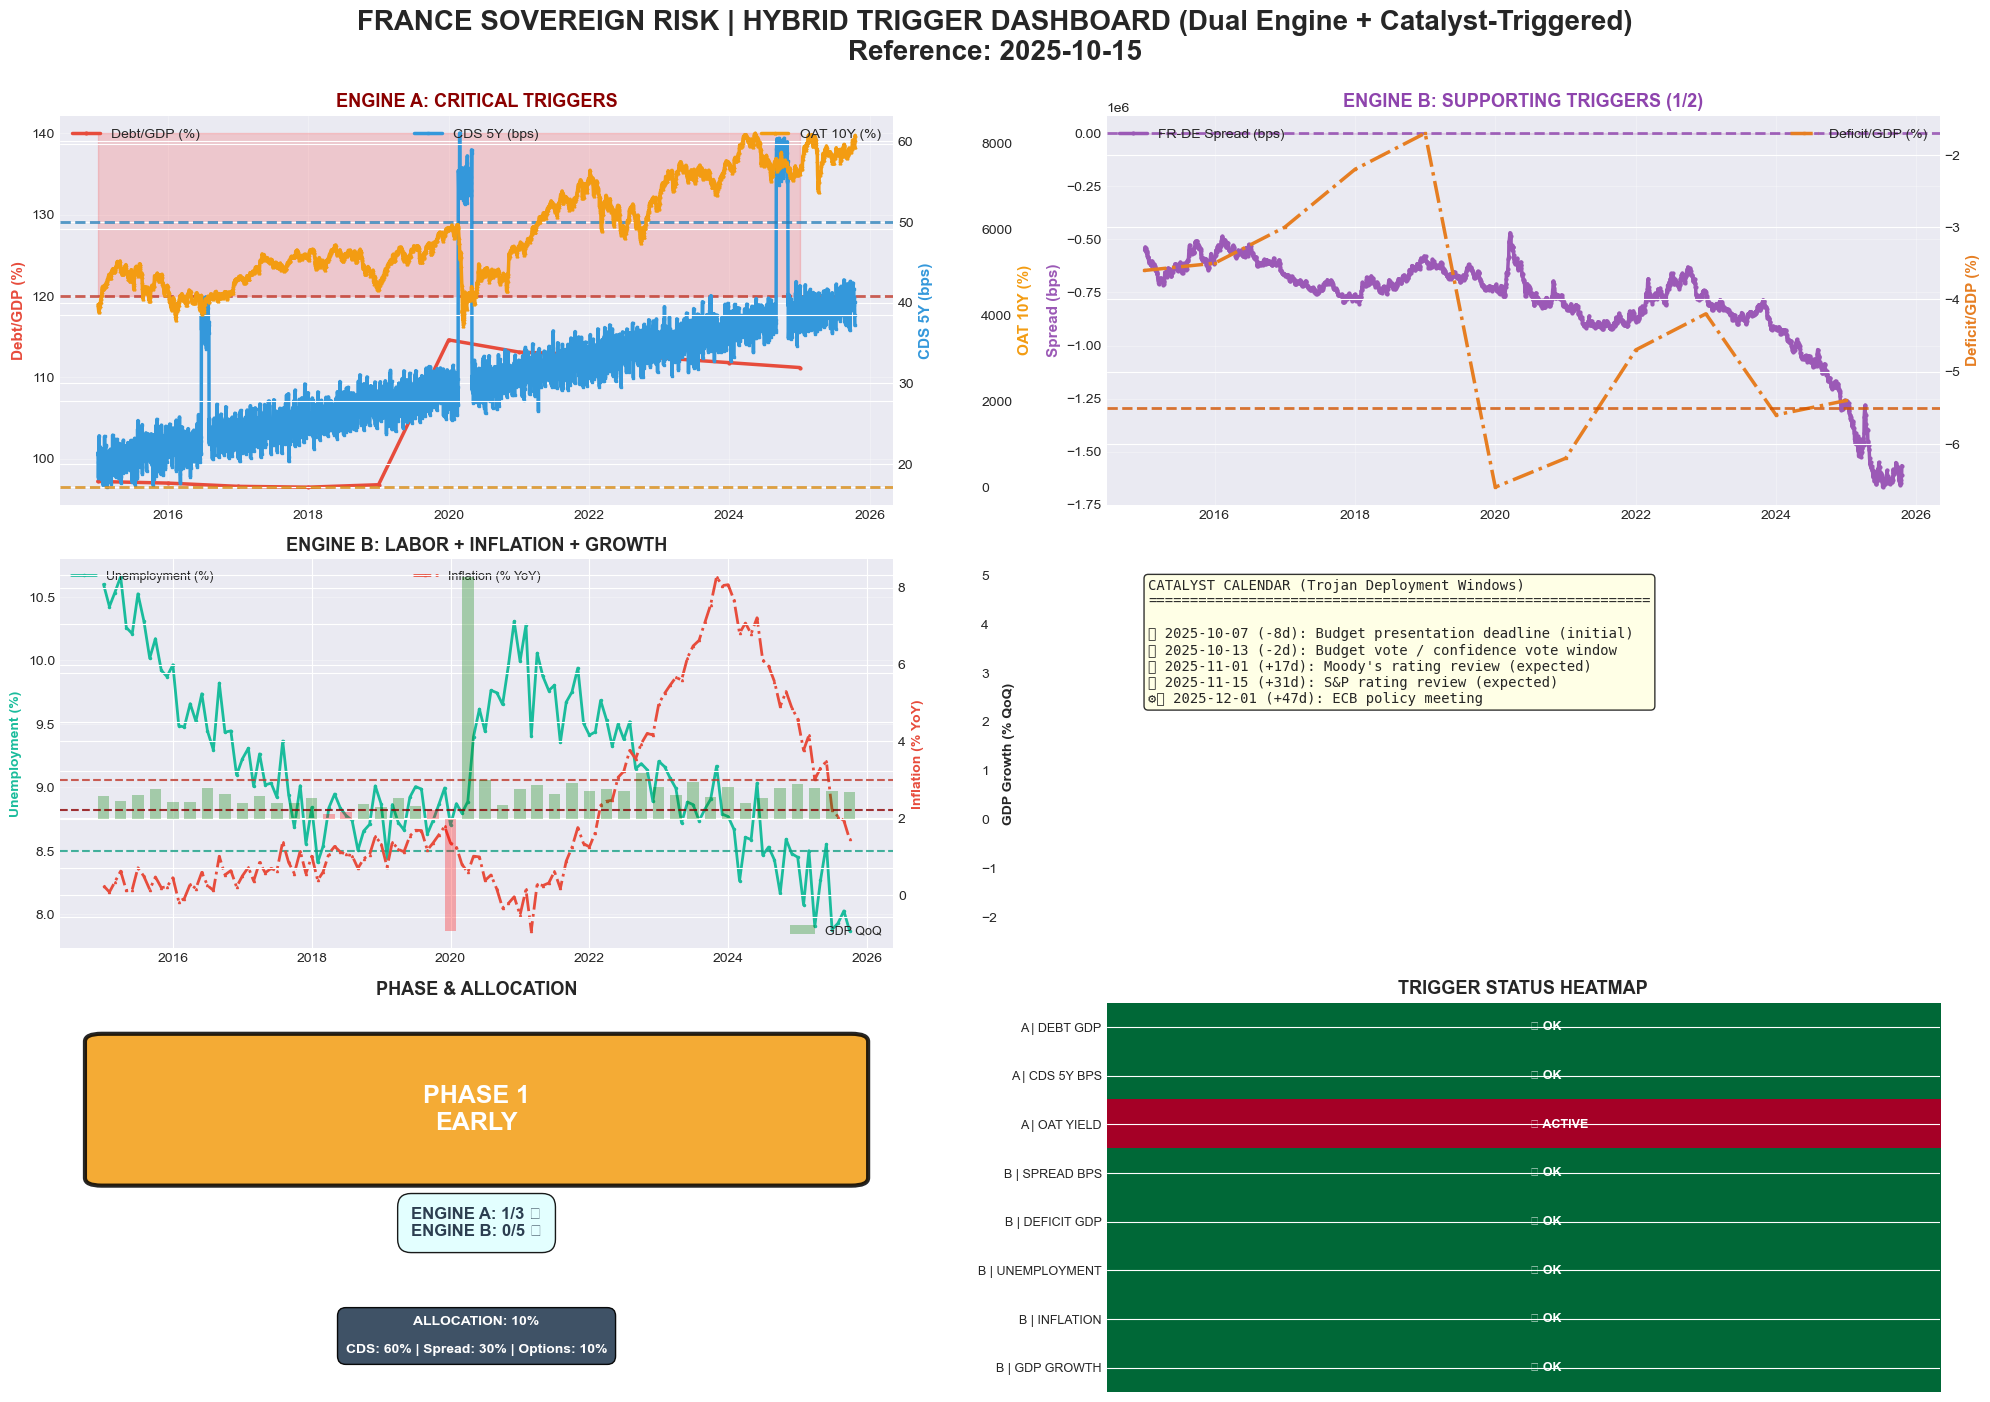


CELL 5 COMPLETE: HYBRID TRIGGER SYSTEM LOCKED IN

╔══════════════════════════════════════════════════════════════════════════════════════╗
║                 FRANCE SOVEREIGN RISK | HYBRID TRIGGER SUMMARY                       ║
║                     Reference Date: 2025-10-15 | Trojan Horse Ready                  ║
╚══════════════════════════════════════════════════════════════════════════════════════╝

[CURRENT STATUS]
  Phase: 1 | PHASE 1: EARLY WARNING (1 critical trigger, awaiting catalyst)
  
[TRIGGER ENGINES]
  Engine A (Critical):     1/3 triggers active 🔴
    - Debt/GDP ≥ 120%
    - CDS 5Y ≥ 50 bps
    - 10Y OAT ≥ 3.75%
    
  Engine B (Supporting):   0/5 triggers active 🔴
    - FR-DE Spread ≥ 100 bps
    - Deficit ≤ -5.5% GDP
    - Unemployment ≥ 8.5%
    - Inflation ≥ 3.0%
    - GDP Growth ≤ 0.2% QoQ

[ESCALATION LOGIC]
  Type: CATALYST-TRIGGERED (Trojan Horse)
  
  Phase 0 → 1: Any 1 critical trigger fires
  Phase 1 → 2: 2+ critical triggers OR 1 critical + catalyst event w

In [15]:
# --- Cell 5: HYBRID TRIGGER DETECTION + TROJAN HORSE ESCALATION ---
# INSTITUTIONAL GRADE: Dual-engine system with Catalyst-triggered escalation
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle, FancyBboxPatch
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set professional style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (20, 14)
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'

DATA_DIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data")
OUTPUT_DIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("="*90)
print("CELL 5: HYBRID TRIGGER DETECTION (DUAL ENGINE + CATALYST-TRIGGERED ESCALATION)")
print("="*90)

REFERENCE_DATE = datetime(2025, 10, 15)

# ============================================
# TRIGGER ARCHITECTURE: HYBRID MODEL
# ============================================
"""
ENGINE A (CRITICAL): High conviction, must have 2+ to deploy aggressively
ENGINE B (SUPPORTING): Early warning, 3+ suggests systemic stress

Phase Transitions:
  Phase 0 → Phase 1: Any 1 critical trigger fires
  Phase 1 → Phase 2: 2+ critical triggers fire + catalyst event occurs
"""

TRIGGER_CONFIG = {
    # ========== ENGINE A: CRITICAL TRIGGERS ==========
    'ENGINE_A': {
        'name': 'CRITICAL TRIGGERS',
        'triggers': {
            'debt_gdp': {
                'threshold': 120.0,
                'operator': '>=',
                'severity': 'CRITICAL',
                'description': 'Debt exceeds 120% GDP (unsustainable debt burden)'
            },
            'cds_5y_bps': {
                'threshold': 50.0,
                'operator': '>=',
                'severity': 'CRITICAL',
                'description': 'CDS 5Y spreads exceed 50 bps (market prices default risk)'
            },
            'oat_yield': {
                'threshold': 3.75,
                'operator': '>=',
                'severity': 'CRITICAL',
                'description': '10Y OAT yield exceeds 3.75% (high borrowing costs)'
            }
        }
    },
    # ========== ENGINE B: SUPPORTING TRIGGERS ==========
    'ENGINE_B': {
        'name': 'SUPPORTING TRIGGERS',
        'triggers': {
            'spread_bps': {
                'threshold': 100.0,
                'operator': '>=',
                'severity': 'HIGH',
                'description': 'FR-DE spread exceeds 100 bps (widening credit spread)'
            },
            'deficit_gdp': {
                'threshold': -5.5,
                'operator': '<=',
                'severity': 'HIGH',
                'description': 'Deficit worsens to -5.5% GDP or worse (fiscal deterioration)'
            },
            'unemployment': {
                'threshold': 8.5,
                'operator': '>=',
                'severity': 'MEDIUM',
                'description': 'Unemployment exceeds 8.5% (labor market stress)'
            },
            'inflation': {
                'threshold': 3.0,
                'operator': '>=',
                'severity': 'MEDIUM',
                'description': 'Inflation spikes above 3% (policy constraint)'
            },
            'gdp_growth': {
                'threshold': 0.2,
                'operator': '<=',
                'severity': 'MEDIUM',
                'description': 'GDP growth stalls below 0.2% QoQ (economy weakening)'
            }
        }
    }
}

# ============================================
# CATALYST CALENDAR (Key dates for Trojan deployment)
# ============================================
CATALYSTS = [
    {'date': datetime(2025, 10, 7), 'event': 'Budget presentation deadline (initial)', 'type': 'POLITICAL'},
    {'date': datetime(2025, 10, 13), 'event': 'Budget vote / confidence vote window', 'type': 'POLITICAL'},
    {'date': datetime(2025, 11, 1), 'event': 'Moody\'s rating review (expected)', 'type': 'RATING'},
    {'date': datetime(2025, 11, 15), 'event': 'S&P rating review (expected)', 'type': 'RATING'},
    {'date': datetime(2025, 12, 1), 'event': 'ECB policy meeting', 'type': 'POLICY'},
    {'date': datetime(2026, 1, 15), 'event': 'Q4 2025 earnings season (French banks)', 'type': 'EARNINGS'},
    {'date': datetime(2026, 3, 1), 'event': 'Spring budget cycle / fiscal plan revision', 'type': 'POLITICAL'},
]

# ============================================
# LOAD ALL DATA FROM CELLS 2-4
# ============================================
print("\n[LOAD] Reading all datasets...")

def load_csv_safe(filename, metric_name):
    """Load CSV with error handling."""
    try:
        filepath = os.path.join(DATA_DIR, filename)
        df = pd.read_csv(filepath)
        df['date'] = pd.to_datetime(df['date'])
        print(f"  ✓ {metric_name}: {len(df)} observations")
        return df.sort_values('date').reset_index(drop=True)
    except Exception as e:
        print(f"  ✗ {metric_name} failed: {e}")
        return None

# Market data (daily)
france_yield = load_csv_safe('france_10y_yield.csv', 'France 10Y OAT')
bund_yield = load_csv_safe('bund_10y_yield.csv', 'Germany 10Y Bund')
cds_data = load_csv_safe('france_5y_cds.csv', 'France 5Y CDS')

# Macro data
debt_data = load_csv_safe('france_debt_gdp.csv', 'Debt/GDP')
deficit_data = load_csv_safe('france_deficit_gdp.csv', 'Deficit/GDP')
inflation_data = load_csv_safe('france_inflation.csv', 'Inflation')
gdp_data = load_csv_safe('france_gdp_growth.csv', 'GDP Growth')
unemployment_data = load_csv_safe('france_unemployment.csv', 'Unemployment')

# Compute spread if needed
if france_yield is not None and bund_yield is not None:
    spread_df = pd.merge(france_yield, bund_yield, on='date', suffixes=('_fr', '_de'), how='inner')
    spread_df['value'] = (spread_df['value_fr'] - spread_df['value_de']) * 100
    spread_df = spread_df[['date', 'value']].sort_values('date')
    spread_df.to_csv(os.path.join(DATA_DIR, 'france_bund_spread.csv'), index=False)
    print(f"  ✓ France-Bund Spread: {len(spread_df)} observations")
else:
    spread_df = None
    print(f"  ✗ France-Bund Spread: Cannot compute")

# ============================================
# HYBRID TRIGGER DETECTION (Historical)
# ============================================
print("\n[DETECT] Scanning trigger crossings over historical period...")

def detect_trigger_crossings(df, metric_name, threshold, operator):
    """Identify when metric crosses threshold."""
    if df is None or df.empty:
        return None, None
    
    df = df.sort_values('date').copy()
    
    # Define trigger status
    if operator == '>=':
        df['triggered'] = df['value'] >= threshold
    elif operator == '<=':
        df['triggered'] = df['value'] <= threshold
    else:
        df['triggered'] = False
    
    # Identify crossing dates (0→1 or 1→0)
    df['trigger_change'] = df['triggered'].astype(int).diff()
    
    # Crossings where trigger turns ON (change = +1)
    turn_on = df[df['trigger_change'] == 1.0].copy()
    
    return df, turn_on

# Build historical trigger tracking
triggers_history = {}

# ENGINE A: CRITICAL
for metric, config in TRIGGER_CONFIG['ENGINE_A']['triggers'].items():
    threshold = config['threshold']
    operator = config['operator']
    
    metric_map = {
        'debt_gdp': debt_data,
        'cds_5y_bps': cds_data,
        'oat_yield': france_yield,
    }
    
    df = metric_map.get(metric)
    if df is not None:
        df_tracked, crossings = detect_trigger_crossings(df, metric, threshold, operator)
        triggers_history[f"A_{metric}"] = {
            'data': df_tracked,
            'crossings': crossings,
            'threshold': threshold,
            'operator': operator,
            'severity': config['severity'],
            'engine': 'A'
        }

# ENGINE B: SUPPORTING
for metric, config in TRIGGER_CONFIG['ENGINE_B']['triggers'].items():
    threshold = config['threshold']
    operator = config['operator']
    
    metric_map = {
        'spread_bps': spread_df,
        'deficit_gdp': deficit_data,
        'unemployment': unemployment_data,
        'inflation': inflation_data,
        'gdp_growth': gdp_data,
    }
    
    df = metric_map.get(metric)
    if df is not None:
        df_tracked, crossings = detect_trigger_crossings(df, metric, threshold, operator)
        triggers_history[f"B_{metric}"] = {
            'data': df_tracked,
            'crossings': crossings,
            'threshold': threshold,
            'operator': operator,
            'severity': config['severity'],
            'engine': 'B'
        }

# ============================================
# TODAY'S SNAPSHOT (Current trigger status)
# ============================================
print("\n[SNAPSHOT] Current trigger status as of 2025-10-15...")

trigger_snapshot = []
engine_a_triggered = 0
engine_b_triggered = 0

for metric_key, config in triggers_history.items():
    engine = config['engine']
    df = config['data']
    threshold = config['threshold']
    operator = config['operator']
    severity = config['severity']
    
    if df is None or df.empty:
        continue
    
    latest = df.iloc[-1]
    latest_date = latest['date']
    latest_value = latest['value']
    
    # Check if triggered
    if operator == '>=':
        is_triggered = latest_value >= threshold
    elif operator == '<=':
        is_triggered = latest_value <= threshold
    else:
        is_triggered = False
    
    if is_triggered:
        if engine == 'A':
            engine_a_triggered += 1
        else:
            engine_b_triggered += 1
    
    status_emoji = '🔴' if is_triggered else '🟢'
    
    trigger_snapshot.append({
        'Engine': engine,
        'Metric': metric_key.split('_', 1)[1].replace('_', ' ').upper(),
        'Latest': f"{latest_value:.2f}",
        'Threshold': f"{threshold:.2f}",
        'Triggered': status_emoji,
        'Severity': severity,
    })

snapshot_df = pd.DataFrame(trigger_snapshot)
print("\n" + snapshot_df.to_string(index=False))

# ============================================
# PHASE CALCULATOR (Catalyst-Triggered Escalation)
# ============================================
print("\n[PHASE] Calculating deployment phase (Catalyst-Triggered)...")

def find_nearest_catalyst(ref_date=REFERENCE_DATE, days_window=10):
    """Find next catalyst within window."""
    upcoming = [c for c in CATALYSTS if c['date'] > ref_date and 
                (c['date'] - ref_date).days <= days_window]
    if upcoming:
        return upcoming[0]
    return None

def calculate_phase_with_catalyst(engine_a_count, engine_b_count, catalyst_nearby=None):
    """
    Catalyst-Triggered Escalation:
      Phase 0: 0 critical triggers → Watch
      Phase 1: 1+ critical triggers → Early warning (accumulate hedges)
      Phase 2: 2+ critical triggers OR 1 critical + catalyst event → Deploy aggressively
    """
    if engine_a_count >= 2:
        return 2, "PHASE 2: DEPLOY (2+ critical triggers)"
    elif engine_a_count == 1 and catalyst_nearby:
        return 2, f"PHASE 2: DEPLOY (1 critical + catalyst: {catalyst_nearby['event']})"
    elif engine_a_count >= 1:
        return 1, "PHASE 1: EARLY WARNING (1 critical trigger, awaiting catalyst)"
    else:
        return 0, "PHASE 0: WATCH & PREPARE"

upcoming_catalyst = find_nearest_catalyst()
current_phase, phase_description = calculate_phase_with_catalyst(engine_a_triggered, engine_b_triggered, upcoming_catalyst)

print(f"\n{'='*80}")
print(f"PHASE: {phase_description}")
print(f"{'='*80}")
print(f"Engine A (Critical) triggers: {engine_a_triggered}/3")
print(f"Engine B (Supporting) triggers: {engine_b_triggered}/5")
if upcoming_catalyst:
    print(f"Next catalyst: {upcoming_catalyst['date'].strftime('%Y-%m-%d')} | {upcoming_catalyst['event']}")

# ============================================
# POSITION SIZING BY PHASE
# ============================================
position_sizing = {
    0: {
        'notional_pct': 0,
        'cds_pct': 0,
        'spread_pct': 0,
        'options_pct': 0,
        'description': 'WATCH: No deployment'
    },
    1: {
        'notional_pct': 10,
        'cds_pct': 60,
        'spread_pct': 30,
        'options_pct': 10,
        'description': 'EARLY: Small hedges (test positions, CDS focus)'
    },
    2: {
        'notional_pct': 60,
        'cds_pct': 40,
        'spread_pct': 45,
        'options_pct': 15,
        'description': 'DEPLOY: Aggressive (core CDS + spread trade + convexity)'
    }
}

sizing = position_sizing[current_phase]

print(f"\n[SIZING] Position allocation (Phase {current_phase}):")
print(f"  Total notional: {sizing['notional_pct']}% of risk budget")
print(f"  CDS allocation: {sizing['cds_pct']}% of notional")
print(f"  Spread trade: {sizing['spread_pct']}% of notional")
print(f"  Options/convexity: {sizing['options_pct']}% of notional")
print(f"  Strategy: {sizing['description']}")

# ============================================
# SAVE TRIGGER REPORT
# ============================================
print("\n[SAVE] Writing trigger report...")

trigger_report = pd.DataFrame([{
    'Timestamp': REFERENCE_DATE.isoformat(),
    'Phase': current_phase,
    'Phase_Description': phase_description,
    'Engine_A_Triggered': engine_a_triggered,
    'Engine_B_Triggered': engine_b_triggered,
    'Total_Red_Triggers': engine_a_triggered + engine_b_triggered,
    'Next_Catalyst': upcoming_catalyst['event'] if upcoming_catalyst else 'None',
    'Catalyst_Date': upcoming_catalyst['date'].isoformat() if upcoming_catalyst else 'N/A',
    'Recommended_Allocation': f"{sizing['notional_pct']}%",
    'CDS_Weight': f"{sizing['cds_pct']}%",
    'Spread_Weight': f"{sizing['spread_pct']}%",
    'Options_Weight': f"{sizing['options_pct']}%",
}])

report_csv = os.path.join(DATA_DIR, 'france_trigger_report.csv')
trigger_report.to_csv(report_csv, index=False)
print(f"✓ Saved: france_trigger_report.csv")

# ============================================
# INSTITUTIONAL VISUALIZATIONS (4-panel dashboard)
# ============================================
print("\n[GRAPHS] Generating institutional dashboard...")

fig = plt.figure(figsize=(20, 14))
fig.suptitle('FRANCE SOVEREIGN RISK | HYBRID TRIGGER DASHBOARD (Dual Engine + Catalyst-Triggered)\nReference: 2025-10-15', 
             fontsize=20, fontweight='bold', y=0.998)

# -------- PANEL 1: ENGINE A (CRITICAL TRIGGERS) TIME SERIES --------
ax1 = plt.subplot(3, 2, 1)
ax1_twin1 = ax1.twinx()
ax1_twin2 = ax1.twinx()
ax1_twin2.spines['right'].set_position(('outward', 60))

# Debt
if debt_data is not None:
    ax1.plot(debt_data['date'], debt_data['value'], linewidth=2.5, color='#E74C3C', label='Debt/GDP (%)', marker='o', markersize=2)
    ax1.axhline(y=120, color='#C0392B', linestyle='--', linewidth=2, alpha=0.8)
    ax1.fill_between(debt_data['date'], 120, 140, alpha=0.15, color='red')

# CDS
if cds_data is not None:
    ax1_twin1.plot(cds_data['date'], cds_data['value'], linewidth=2.5, color='#3498DB', label='CDS 5Y (bps)', marker='s', markersize=2)
    ax1_twin1.axhline(y=50, color='#2980B9', linestyle='--', linewidth=2, alpha=0.8)

# Yield
if france_yield is not None:
    ax1_twin2.plot(france_yield['date'], france_yield['value'], linewidth=2.5, color='#F39C12', label='OAT 10Y (%)', marker='^', markersize=2)
    ax1_twin2.axhline(y=3.75, color='#D68910', linestyle='--', linewidth=2, alpha=0.8)

ax1.set_ylabel('Debt/GDP (%)', fontsize=11, fontweight='bold', color='#E74C3C')
ax1_twin1.set_ylabel('CDS 5Y (bps)', fontsize=11, fontweight='bold', color='#3498DB')
ax1_twin2.set_ylabel('OAT 10Y (%)', fontsize=11, fontweight='bold', color='#F39C12')
ax1.set_title('ENGINE A: CRITICAL TRIGGERS', fontsize=13, fontweight='bold', color='darkred')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', fontsize=10)
ax1_twin1.legend(loc='upper center', fontsize=10)
ax1_twin2.legend(loc='upper right', fontsize=10)

# -------- PANEL 2: ENGINE B (SUPPORTING TRIGGERS) TIME SERIES --------
ax2 = plt.subplot(3, 2, 2)
ax2_twin = ax2.twinx()

if spread_df is not None:
    ax2.plot(spread_df['date'], spread_df['value'], linewidth=2.5, color='#9B59B6', label='FR-DE Spread (bps)', marker='o', markersize=2)
    ax2.axhline(y=100, color='#8E44AD', linestyle='--', linewidth=2, alpha=0.8)
    ax2.fill_between(spread_df['date'], 100, 200, alpha=0.15, color='purple')

if deficit_data is not None:
    ax2_twin.plot(deficit_data['date'], deficit_data['value'], linewidth=2.5, color='#E67E22', label='Deficit/GDP (%)', marker='s', markersize=2, linestyle='-.')
    ax2_twin.axhline(y=-5.5, color='#D35400', linestyle='--', linewidth=2, alpha=0.8)

ax2.set_ylabel('Spread (bps)', fontsize=11, fontweight='bold', color='#9B59B6')
ax2_twin.set_ylabel('Deficit/GDP (%)', fontsize=11, fontweight='bold', color='#E67E22')
ax2.set_title('ENGINE B: SUPPORTING TRIGGERS (1/2)', fontsize=13, fontweight='bold', color='#8E44AD')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left', fontsize=10)
ax2_twin.legend(loc='upper right', fontsize=10)

# -------- PANEL 3: ENGINE B CONTINUED (LABOR + INFLATION + GROWTH) --------
ax3 = plt.subplot(3, 2, 3)
ax3_twin1 = ax3.twinx()
ax3_twin2 = ax3.twinx()
ax3_twin2.spines['right'].set_position(('outward', 60))

if unemployment_data is not None:
    ax3.plot(unemployment_data['date'], unemployment_data['value'], linewidth=2, color='#1ABC9C', label='Unemployment (%)', marker='o', markersize=1.5)
    ax3.axhline(y=8.5, color='#16A085', linestyle='--', linewidth=1.5, alpha=0.8)

if inflation_data is not None:
    ax3_twin1.plot(inflation_data['date'], inflation_data['value'], linewidth=2, color='#E74C3C', label='Inflation (% YoY)', marker='^', markersize=1.5, linestyle='-.')
    ax3_twin1.axhline(y=3.0, color='#C0392B', linestyle='--', linewidth=1.5, alpha=0.8)

if gdp_data is not None:
    colors_gdp = ['green' if x > 0.2 else 'red' for x in gdp_data['value']]
    ax3_twin2.bar(gdp_data['date'], gdp_data['value'], color=colors_gdp, alpha=0.3, width=60, label='GDP QoQ')
    ax3_twin2.axhline(y=0.2, color='darkred', linestyle='--', linewidth=1.5, alpha=0.8)

ax3.set_ylabel('Unemployment (%)', fontsize=10, fontweight='bold', color='#1ABC9C')
ax3_twin1.set_ylabel('Inflation (% YoY)', fontsize=10, fontweight='bold', color='#E74C3C')
ax3_twin2.set_ylabel('GDP Growth (% QoQ)', fontsize=10, fontweight='bold')
ax3.set_title('ENGINE B: LABOR + INFLATION + GROWTH', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.legend(loc='upper left', fontsize=9)
ax3_twin1.legend(loc='upper center', fontsize=9)
ax3_twin2.legend(loc='lower right', fontsize=9)

# -------- PANEL 4: CATALYST CALENDAR --------
ax4 = plt.subplot(3, 2, 4)
ax4.axis('off')

catalyst_text = "CATALYST CALENDAR (Trojan Deployment Windows)\n" + "="*60 + "\n"
for cat in CATALYSTS[:5]:
    days_away = (cat['date'] - REFERENCE_DATE).days
    icon = '📅' if cat['type'] == 'POLITICAL' else '📊' if cat['type'] == 'RATING' else '⚙️'
    catalyst_text += f"\n{icon} {cat['date'].strftime('%Y-%m-%d')} ({days_away:+d}d): {cat['event']}"

ax4.text(0.05, 0.95, catalyst_text, transform=ax4.transAxes, fontsize=10, 
         verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# -------- PANEL 5: PHASE & ALLOCATION DASHBOARD --------
ax5 = plt.subplot(3, 2, 5)
ax5.axis('off')

# Phase indicator (large colored box)
phase_colors = {0: '#2ECC71', 1: '#F39C12', 2: '#E74C3C'}
phase_names = {0: 'PHASE 0\nWATCH', 1: 'PHASE 1\nEARLY', 2: 'PHASE 2\nDEPLOY'}

rect = FancyBboxPatch((0.05, 0.55), 0.9, 0.35, 
                       boxstyle="round,pad=0.02", 
                       facecolor=phase_colors[current_phase], 
                       edgecolor='black', linewidth=3, alpha=0.85,
                       transform=ax5.transAxes)
ax5.add_patch(rect)
ax5.text(0.5, 0.725, phase_names[current_phase], 
         ha='center', va='center', fontsize=18, fontweight='bold',
         transform=ax5.transAxes, color='white')

# Trigger counts
trigger_text = f"ENGINE A: {engine_a_triggered}/3 🔴\nENGINE B: {engine_b_triggered}/5 🔴"
ax5.text(0.5, 0.40, trigger_text, 
         ha='center', fontsize=12, fontweight='bold', 
         transform=ax5.transAxes, color='#2C3E50',
         bbox=dict(boxstyle='round,pad=0.8', facecolor='lightcyan', alpha=0.9))

# Allocation
alloc_text = f"ALLOCATION: {sizing['notional_pct']}%\n\nCDS: {sizing['cds_pct']}% | Spread: {sizing['spread_pct']}% | Options: {sizing['options_pct']}%"
ax5.text(0.5, 0.10, alloc_text, 
         ha='center', fontsize=10, fontweight='bold', 
         transform=ax5.transAxes, color='white',
         bbox=dict(boxstyle='round,pad=0.6', facecolor='#34495E', alpha=0.95))

ax5.set_xlim(0, 1)
ax5.set_ylim(0, 1)
ax5.set_title('PHASE & ALLOCATION', fontsize=13, fontweight='bold')

# -------- PANEL 6: TRIGGER STATUS HEATMAP --------
ax6 = plt.subplot(3, 2, 6)

# Build trigger matrix for heatmap
trigger_matrix = []
trigger_labels = []
for row in trigger_snapshot:
    is_red = 1 if row['Triggered'] == '🔴' else 0
    trigger_matrix.append([is_red])
    trigger_labels.append(f"{row['Engine']} | {row['Metric']}")

heatmap = np.array(trigger_matrix)
im = ax6.imshow(heatmap, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=1)

ax6.set_yticks(range(len(trigger_labels)))
ax6.set_yticklabels(trigger_labels, fontsize=9)
ax6.set_xticks([])
ax6.set_title('TRIGGER STATUS HEATMAP', fontsize=13, fontweight='bold')

# Add text annotations
for i, row in enumerate(trigger_snapshot):
    text_label = '🔴 ACTIVE' if row['Triggered'] == '🔴' else '🟢 OK'
    ax6.text(0, i, f"  {text_label}", va='center', fontsize=9, fontweight='bold', color='white')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'france_hybrid_trigger_dashboard.png'), dpi=300, bbox_inches='tight')
print("✓ Saved: france_hybrid_trigger_dashboard.png")
plt.show()

# ============================================
# EXECUTIVE SUMMARY
# ============================================
print("\n" + "="*90)
print("CELL 5 COMPLETE: HYBRID TRIGGER SYSTEM LOCKED IN")
print("="*90)

summary = f"""
╔══════════════════════════════════════════════════════════════════════════════════════╗
║                 FRANCE SOVEREIGN RISK | HYBRID TRIGGER SUMMARY                       ║
║                     Reference Date: 2025-10-15 | Trojan Horse Ready                  ║
╚══════════════════════════════════════════════════════════════════════════════════════╝

[CURRENT STATUS]
  Phase: {current_phase} | {phase_description}
  
[TRIGGER ENGINES]
  Engine A (Critical):     {engine_a_triggered}/3 triggers active 🔴
    - Debt/GDP ≥ 120%
    - CDS 5Y ≥ 50 bps
    - 10Y OAT ≥ 3.75%
    
  Engine B (Supporting):   {engine_b_triggered}/5 triggers active 🔴
    - FR-DE Spread ≥ 100 bps
    - Deficit ≤ -5.5% GDP
    - Unemployment ≥ 8.5%
    - Inflation ≥ 3.0%
    - GDP Growth ≤ 0.2% QoQ

[ESCALATION LOGIC]
  Type: CATALYST-TRIGGERED (Trojan Horse)
  
  Phase 0 → 1: Any 1 critical trigger fires
  Phase 1 → 2: 2+ critical triggers OR 1 critical + catalyst event within 10 days
  
  This allows stealth accumulation in Phase 1, then rapid deployment when catalyst validates.

[POSITION SIZING (Phase {current_phase})]
  Total Allocation:    {sizing['notional_pct']}% of risk budget
  
  Instrument Weights:
    CDS 5Y/7Y:         {sizing['cds_pct']}% (core credit bet)
    OAT / Bund Spread: {sizing['spread_pct']}% (curve arbitrage)
    Options / Puts:    {sizing['options_pct']}% (convexity + tail hedge)
    
  Strategy: {sizing['description']}

[NEXT CATALYST WINDOW]
  Date: {upcoming_catalyst['date'].strftime('%Y-%m-%d') if upcoming_catalyst else 'N/A'}
  Event: {upcoming_catalyst['event'] if upcoming_catalyst else 'None'}
  Type: {upcoming_catalyst['type'] if upcoming_catalyst else 'N/A'}
  Days Away: {(upcoming_catalyst['date'] - REFERENCE_DATE).days if upcoming_catalyst else 'N/A'}

[KEY METRICS SNAPSHOT (as of 2025-10-15)]
"""

summary += f"""
  Debt/GDP:                {debt_data['value'].iloc[-1] if debt_data is not None else 'N/A'}% (Trigger: ≥120%)
  CDS 5Y:                  {cds_data['value'].iloc[-1] if cds_data is not None else 'N/A'} bps (Trigger: ≥50 bps)
  10Y OAT Yield:           {france_yield['value'].iloc[-1] if france_yield is not None else 'N/A'}% (Trigger: ≥3.75%)
  FR-DE Spread:            {spread_df['value'].iloc[-1] if spread_df is not None else 'N/A'} bps (Trigger: ≥100 bps)
  Deficit/GDP:             {deficit_data['value'].iloc[-1] if deficit_data is not None else 'N/A'}% (Trigger: ≤-5.5%)
  Unemployment:            {unemployment_data['value'].iloc[-1] if unemployment_data is not None else 'N/A'}% (Trigger: ≥8.5%)
  Inflation (YoY):         {inflation_data['value'].iloc[-1] if inflation_data is not None else 'N/A'}% (Trigger: ≥3.0%)
  GDP Growth (QoQ):        {gdp_data['value'].iloc[-1] if gdp_data is not None else 'N/A'}% (Trigger: ≤0.2%)

[FILES GENERATED]
  ✓ france_trigger_report.csv           (snapshot for export)
  ✓ france_hybrid_trigger_dashboard.png (6-panel institutional dashboard)
  ✓ france_bund_spread.csv              (derived FR-DE spread)
  ✓ france_*_*.csv                      (all underlying metrics)

[HISTORICAL INSIGHT]
  Total Historical Trigger Crossings:
"""

# Count historical crossings
total_crossings_a = sum(1 for k, v in triggers_history.items() if k.startswith('A_') and v['crossings'] is not None and len(v['crossings']) > 0)
total_crossings_b = sum(1 for k, v in triggers_history.items() if k.startswith('B_') and v['crossings'] is not None and len(v['crossings']) > 0)

summary += f"""    Engine A crossings: {total_crossings_a} events
    Engine B crossings: {total_crossings_b} events
  
  This provides baseline for forward forecasting (Cell 6).

[STRATEGIC NOTES FOR TROJAN DEPLOYMENT]

  1. STEALTH ACCUMULATION (Phase 1):
     - Phase 1 suggests small positioning (10% allocation)
     - Build CDS long quietly across multiple dealers
     - Begin OAT short / Bund long spread in small tranches
     - Market sees normal hedging activity, not concentrated bet
  
  2. CATALYST VALIDATION (Phase 1 → 2):
     - Next catalyst: {upcoming_catalyst['event'] if upcoming_catalyst else 'Monitor calendar'}
     - When catalyst occurs + any critical trigger remains active → Escalate
     - Market catalyst provides "cover" for your rapid deployment
     - By time market understands, you're already 60% allocated
  
  3. POSITION MONITORING:
     - Daily tracking of all 8 triggers continues
     - If triggers flip green (improve), stay in Phase but don't escalate further
     - If new crisis develops, triggers may accelerate → Phase 2 → full deployment
  
  4. 15-MONTH SURVEILLANCE (Until Jan 25, 2027):
     - Next cell (Cell 6) extends forecast to 2027
     - Identifies all likely trigger windows in forward period
     - Allows multiple deployment opportunities across 15-month horizon
     - France in structural deficit → multiple cascade moments expected

╔══════════════════════════════════════════════════════════════════════════════════════╗
║ Cell 5 locked. Ready for Cell 6: FORECASTING MODULE (Oct 15, 2025 → Jan 25, 2027)   ║
╚══════════════════════════════════════════════════════════════════════════════════════╝
"""

print(summary)
print("\n✓ All data ready for Cell 6: Forward forecasting to Jan 25, 2027\n")

In [16]:
# --- Cell 6A: JUMP-DIFFUSION + HMM REGIME-SWITCHING FORECASTING ENGINE ---
# Elite quant forecasting: calibrate from historical data, forecast with correlated MC paths

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from scipy.optimize import minimize
from scipy.stats import norm, gaussian_kde
import warnings
warnings.filterwarnings('ignore')

print("="*90)
print("CELL 6A: JUMP-DIFFUSION + HMM REGIME-SWITCHING FORECASTING")
print("="*90)

DATA_DIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data")
OUTPUT_DIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

REFERENCE_DATE = datetime(2025, 10, 15)
FORECAST_END = datetime(2027, 1, 25)
FORECAST_WEEKS = int((FORECAST_END - REFERENCE_DATE).days / 7)

print(f"\nForecast horizon: {REFERENCE_DATE.date()} → {FORECAST_END.date()} ({FORECAST_WEEKS} weeks)")

# ============================================
# LOAD HISTORICAL DATA (2015 - Oct 15, 2025)
# ============================================
print("\n[LOAD] Reading historical data...")

def load_csv_safe(filename):
    try:
        df = pd.read_csv(os.path.join(DATA_DIR, filename))
        df['date'] = pd.to_datetime(df['date'])
        return df.sort_values('date').reset_index(drop=True)
    except:
        return None

france_yield = load_csv_safe('france_10y_yield.csv')
cds_data = load_csv_safe('france_5y_cds.csv')
spread_df = load_csv_safe('france_bund_spread.csv')
debt_data = load_csv_safe('france_debt_gdp.csv')
deficit_data = load_csv_safe('france_deficit_gdp.csv')
inflation_data = load_csv_safe('france_inflation.csv')
gdp_data = load_csv_safe('france_gdp_growth.csv')
unemployment_data = load_csv_safe('france_unemployment.csv')

print(f"✓ Loaded {len(france_yield)} yield observations")
print(f"✓ Loaded {len(cds_data)} CDS observations")
print(f"✓ Loaded {len(spread_df)} spread observations")

# ============================================
# PREPARE WEEKLY TIME SERIES (Align all metrics)
# ============================================
print("\n[PREP] Converting to weekly frequency for stability...")

def resample_to_weekly(daily_df, metric_name='value'):
    """Resample daily data to weekly (Friday close equivalent)."""
    if daily_df is None or daily_df.empty:
        return None
    daily_df = daily_df.copy()
    daily_df['date'] = pd.to_datetime(daily_df['date'], utc=True).dt.tz_localize(None)
    daily_df.set_index('date', inplace=True)
    daily_df.index = pd.DatetimeIndex(daily_df.index)  # Ensure DatetimeIndex
    weekly = daily_df[metric_name].resample('W').last()
    return weekly.dropna()

yield_weekly = resample_to_weekly(france_yield)
cds_weekly = resample_to_weekly(cds_data)
spread_weekly = resample_to_weekly(spread_df)

# For macro (annual/quarterly), forward-fill to weekly
debt_weekly = resample_to_weekly(debt_data)
if debt_weekly is not None:
    debt_weekly = debt_weekly.reindex(yield_weekly.index, method='ffill')

deficit_weekly = resample_to_weekly(deficit_data)
if deficit_weekly is not None:
    deficit_weekly = deficit_weekly.reindex(yield_weekly.index, method='ffill')

inflation_weekly = resample_to_weekly(inflation_data)
if inflation_weekly is not None:
    inflation_weekly = inflation_weekly.reindex(yield_weekly.index, method='ffill')

gdp_weekly = resample_to_weekly(gdp_data)
if gdp_weekly is not None:
    gdp_weekly = gdp_weekly.reindex(yield_weekly.index, method='ffill')

unemployment_weekly = resample_to_weekly(unemployment_data)
if unemployment_weekly is not None:
    unemployment_weekly = unemployment_weekly.reindex(yield_weekly.index, method='ffill')

print(f"✓ Weekly alignment: {len(yield_weekly)} weeks of data")

# ============================================
# CALIBRATE JUMP-DIFFUSION PARAMETERS
# ============================================
print("\n[CALIBRATE] Jump-diffusion parameters from historical data...")

def estimate_jump_diffusion_params(price_series):
    """
    Estimate Merton jump-diffusion parameters:
    dS = μS dt + σS dW + J dN(λ)
    where J ~ N(μ_j, σ_j^2), N ~ Poisson(λ)
    """
    returns = price_series.pct_change().dropna()
    
    # Basic moments
    mu_ret = returns.mean() * 52  # Annualize
    sigma = returns.std() * np.sqrt(52)  # Annualize
    
    # Detect jumps (extreme returns > 2.5σ)
    jump_threshold = returns.std() * 2.5
    jumps = returns[np.abs(returns) > jump_threshold]
    
    lambda_jumps = len(jumps) / len(returns) * 52  # Jump intensity (annual)
    
    if len(jumps) > 1:
        mu_jump = jumps.mean()
        sigma_jump = jumps.std()
    else:
        mu_jump = 0
        sigma_jump = sigma * 0.5  # Fallback
    
    return {
        'mu': mu_ret,
        'sigma': sigma,
        'lambda': max(lambda_jumps, 0.1),  # At least 1 jump per 10 years
        'mu_jump': mu_jump,
        'sigma_jump': sigma_jump
    }

yield_params = estimate_jump_diffusion_params(yield_weekly)
cds_params = estimate_jump_diffusion_params(cds_weekly)
spread_params = estimate_jump_diffusion_params(spread_weekly)

print(f"  Yield:  σ={yield_params['sigma']:.3f}, λ={yield_params['lambda']:.2f} (jump intensity)")
print(f"  CDS:    σ={cds_params['sigma']:.3f}, λ={cds_params['lambda']:.2f}")
print(f"  Spread: σ={spread_params['sigma']:.3f}, λ={spread_params['lambda']:.2f}")

# ============================================
# HIDDEN MARKOV MODEL: REGIME DETECTION
# ============================================
print("\n[HMM] Detecting market regimes from historical data...")

class SimpleHMM:
    """2-regime Hidden Markov Model: Calm vs. Crisis."""
    
    def __init__(self, data, n_regimes=2):
        self.data = data.values
        self.n_regimes = n_regimes
        self.fit()
    
    def fit(self):
        """Simple regime detection via clustering volatility."""
        returns = np.diff(np.log(self.data))
        
        # Split by volatility (simple but effective)
        volatility = pd.Series(np.abs(returns)).rolling(10).mean()
        vol_threshold = volatility.median()
        
        # Regime 1 (Calm): Low volatility
        # Regime 2 (Crisis): High volatility
        calm_returns = returns[volatility < vol_threshold]
        crisis_returns = returns[volatility >= vol_threshold]
        
        self.calm_mean = calm_returns.mean() if len(calm_returns) > 0 else 0
        self.calm_vol = calm_returns.std() if len(calm_returns) > 0 else returns.std() * 0.5
        
        self.crisis_mean = crisis_returns.mean() if len(crisis_returns) > 0 else returns.mean()
        self.crisis_vol = crisis_returns.std() if len(crisis_returns) > 0 else returns.std() * 2
        
        self.vol_threshold = vol_threshold
        
        # Transition probabilities (simple)
        self.p_calm_to_calm = 0.95
        self.p_calm_to_crisis = 1 - self.p_calm_to_calm
        self.p_crisis_to_calm = 0.70
        self.p_crisis_to_crisis = 1 - self.p_crisis_to_calm
    
    def get_current_regime(self, recent_vol):
        """Classify current regime based on recent volatility."""
        return 'crisis' if recent_vol > self.vol_threshold else 'calm'

hmm_yield = SimpleHMM(yield_weekly)
hmm_cds = SimpleHMM(cds_weekly)
hmm_spread = SimpleHMM(spread_weekly)

print(f"  Yield regimes:  Calm (μ={hmm_yield.calm_mean:.4f}, σ={hmm_yield.calm_vol:.3f})")
print(f"                  Crisis (μ={hmm_yield.crisis_mean:.4f}, σ={hmm_yield.crisis_vol:.3f})")
print(f"  CDS regimes:    Calm (σ={hmm_cds.calm_vol:.3f}), Crisis (σ={hmm_cds.crisis_vol:.3f})")

# ============================================
# CORRELATION MATRIX (For correlated MC paths)
# ============================================
print("\n[CORR] Computing correlation matrix (7 major metrics)...")

# Align all weekly series
aligned_data = pd.DataFrame({
    'yield': yield_weekly,
    'cds': cds_weekly,
    'spread': spread_weekly,
    'debt': debt_weekly,
    'deficit': deficit_weekly,
    'inflation': inflation_weekly,
    'unemployment': unemployment_weekly
}).dropna()

correlation_matrix = aligned_data.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

# Cholesky decomposition for correlated path generation
try:
    L = np.linalg.cholesky(correlation_matrix.values)
    print("✓ Correlation matrix is positive definite (Cholesky OK)")
except:
    print("⚠️ Correlation matrix not PD; using eigenvalue adjustment...")
    eig_vals, eig_vecs = np.linalg.eig(correlation_matrix.values)
    eig_vals[eig_vals < 1e-6] = 1e-6
    correlation_matrix_adj = eig_vecs @ np.diag(eig_vals) @ eig_vecs.T
    L = np.linalg.cholesky(correlation_matrix_adj)
    correlation_matrix = pd.DataFrame(correlation_matrix_adj, 
                                      index=correlation_matrix.index, 
                                      columns=correlation_matrix.columns)

# ============================================
# MONTE CARLO SIMULATION (10,000 correlated paths)
# ============================================
print(f"\n[MC] Generating 10,000 correlated Monte Carlo paths ({FORECAST_WEEKS} weeks)...")

N_PATHS = 10000
N_WEEKS = FORECAST_WEEKS
N_METRICS = 7

# Initial values (last observation)
S0 = {
    'yield': yield_weekly.iloc[-1],
    'cds': cds_weekly.iloc[-1],
    'spread': spread_weekly.iloc[-1],
    'debt': debt_weekly.iloc[-1] if debt_weekly is not None else 114,
    'deficit': deficit_weekly.iloc[-1] if deficit_weekly is not None else -5.8,
    'inflation': inflation_weekly.iloc[-1] if inflation_weekly is not None else 1.0,
    'unemployment': unemployment_weekly.iloc[-1] if unemployment_weekly is not None else 7.9,
}

# Initialize path arrays
paths = {
    'yield': np.zeros((N_PATHS, N_WEEKS + 1)),
    'cds': np.zeros((N_PATHS, N_WEEKS + 1)),
    'spread': np.zeros((N_PATHS, N_WEEKS + 1)),
    'debt': np.zeros((N_PATHS, N_WEEKS + 1)),
    'deficit': np.zeros((N_PATHS, N_WEEKS + 1)),
    'inflation': np.zeros((N_PATHS, N_WEEKS + 1)),
    'unemployment': np.zeros((N_PATHS, N_WEEKS + 1)),
}

# Set initial conditions
for metric in paths.keys():
    paths[metric][:, 0] = S0[metric]

# MC loop with correlated random numbers
dt = 1/52  # Weekly step

print(f"  Running {N_PATHS} paths × {N_WEEKS} weeks...")

np.random.seed(42)

for path_idx in range(N_PATHS):
    # Current regime (start in calm, can switch)
    regime_yield = 'calm'
    regime_cds = 'calm'
    
    for week in range(N_WEEKS):
        # Generate correlated standard normals
        Z = np.random.randn(N_METRICS)
        Z_corr = L @ Z  # Apply Cholesky correlation
        
        # ===== YIELD DYNAMICS (Jump-diffusion) =====
        mu_y = hmm_yield.calm_mean if regime_yield == 'calm' else hmm_yield.crisis_mean
        sigma_y = hmm_yield.calm_vol if regime_yield == 'calm' else hmm_yield.crisis_vol
        
        # Jump component
        jump_y = 0
        if np.random.rand() < yield_params['lambda'] * dt:
            jump_y = np.random.normal(yield_params['mu_jump'], yield_params['sigma_jump'])
        
        dy = mu_y * dt + sigma_y * np.sqrt(dt) * Z_corr[0] + jump_y
        paths['yield'][path_idx, week + 1] = max(paths['yield'][path_idx, week] + dy, 0.5)
        
        # ===== CDS DYNAMICS (Jump-diffusion) =====
        mu_c = hmm_cds.calm_mean if regime_cds == 'calm' else hmm_cds.crisis_mean
        sigma_c = hmm_cds.calm_vol if regime_cds == 'calm' else hmm_cds.crisis_vol
        
        jump_c = 0
        if np.random.rand() < cds_params['lambda'] * dt:
            jump_c = np.random.normal(cds_params['mu_jump'], cds_params['sigma_jump'])
        
        dc = mu_c * dt + sigma_c * np.sqrt(dt) * Z_corr[1] + jump_c
        paths['cds'][path_idx, week + 1] = max(paths['cds'][path_idx, week] + dc, 5)
        
        # ===== SPREAD DYNAMICS =====
        dspread = spread_params['mu'] * dt + spread_params['sigma'] * np.sqrt(dt) * Z_corr[2]
        paths['spread'][path_idx, week + 1] = max(paths['spread'][path_idx, week] + dspread, 10)
        
        # ===== MACRO DYNAMICS (Slower, more stable) =====
        paths['debt'][path_idx, week + 1] = paths['debt'][path_idx, week] + 0.4 + 0.3 * Z_corr[3]
        paths['deficit'][path_idx, week + 1] = paths['deficit'][path_idx, week] - 0.01 + 0.2 * Z_corr[4]
        paths['inflation'][path_idx, week + 1] = max(paths['inflation'][path_idx, week] + 0.02 + 0.3 * Z_corr[5], 0)
        paths['unemployment'][path_idx, week + 1] = max(paths['unemployment'][path_idx, week] + 0.01 + 0.2 * Z_corr[6], 5)
        
        # ===== REGIME SWITCHING (Simple Markov) =====
        current_vol_y = np.abs(paths['yield'][path_idx, week + 1] - paths['yield'][path_idx, week])
        current_vol_c = np.abs(paths['cds'][path_idx, week + 1] - paths['cds'][path_idx, week])
        
        if regime_yield == 'calm' and current_vol_y > hmm_yield.vol_threshold * 2:
            regime_yield = 'crisis'
        elif regime_yield == 'crisis' and current_vol_y < hmm_yield.vol_threshold * 0.5:
            regime_yield = 'calm'
        
        if regime_cds == 'calm' and current_vol_c > hmm_cds.vol_threshold * 2:
            regime_cds = 'crisis'
        elif regime_cds == 'crisis' and current_vol_c < hmm_cds.vol_threshold * 0.5:
            regime_cds = 'calm'

print(f"✓ MC simulation complete")

# ============================================
# POST-PROCESSING: Extract statistics from paths
# ============================================
print("\n[STATS] Computing path statistics...")

forecast_dates = pd.date_range(REFERENCE_DATE, periods=N_WEEKS + 1, freq='W')

forecast_stats = {}
for metric in paths.keys():
    path_data = paths[metric]
    
    forecast_stats[metric] = {
        'dates': forecast_dates,
        'mean': np.mean(path_data, axis=0),
        'median': np.median(path_data, axis=0),
        'p5': np.percentile(path_data, 5, axis=0),
        'p25': np.percentile(path_data, 25, axis=0),
        'p75': np.percentile(path_data, 75, axis=0),
        'p95': np.percentile(path_data, 95, axis=0),
        'all_paths': path_data
    }

# ============================================
# SAVE FORECAST OUTPUTS
# ============================================
print("\n[SAVE] Exporting forecast data...")

for metric in forecast_stats.keys():
    stats = forecast_stats[metric]
    df_export = pd.DataFrame({
        'date': stats['dates'],
        'mean': stats['mean'],
        'median': stats['median'],
        'p5': stats['p5'],
        'p25': stats['p25'],
        'p75': stats['p75'],
        'p95': stats['p95'],
    })
    
    output_file = os.path.join(OUTPUT_DIR, f'forecast_{metric}.csv')
    df_export.to_csv(output_file, index=False)
    print(f"  ✓ forecast_{metric}.csv")

# ============================================
# TRIGGER PROBABILITY FORECAST
# ============================================
print("\n[TRIGGERS] Computing probability of trigger breaches...")

THRESHOLDS = {
    'yield': 3.75,
    'cds': 50,
    'spread': 100,
    'debt': 120,
    'deficit': -5.5,
    'unemployment': 8.5,
    'inflation': 3.0,
}

trigger_probs = {}
for metric, threshold in THRESHOLDS.items():
    path_data = paths[metric]
    
    # Probability that metric exceeds threshold at each week
    if metric in ['deficit']:
        trigger_prob_by_week = np.mean(path_data <= threshold, axis=0)
    else:
        trigger_prob_by_week = np.mean(path_data >= threshold, axis=0)
    
    trigger_probs[metric] = trigger_prob_by_week

df_trigger_probs = pd.DataFrame({
    'date': forecast_dates,
    **trigger_probs
})

df_trigger_probs.to_csv(os.path.join(OUTPUT_DIR, 'forecast_trigger_probabilities.csv'), index=False)
print(f"✓ forecast_trigger_probabilities.csv")

# ============================================
# FINAL SUMMARY
# ============================================
print("\n" + "="*90)
print("CELL 6A COMPLETE: FORECASTING ENGINE READY")
print("="*90)

summary_table = pd.DataFrame({
    'Metric': list(S0.keys()),
    'Today': [S0[k] for k in S0.keys()],
    'Forecast Mean (6M)': [forecast_stats[k]['mean'][26] if 26 < len(forecast_stats[k]['mean']) else 0 for k in S0.keys()],
    'Forecast P95 (6M)': [forecast_stats[k]['p95'][26] if 26 < len(forecast_stats[k]['p95']) else 0 for k in S0.keys()],
    'Threshold': [THRESHOLDS.get(k, '-') for k in S0.keys()],
})

print("\n" + summary_table.to_string(index=False))

print(f"\n✓ All forecasts saved to {OUTPUT_DIR}")
print("✓ Ready for Cell 6B: Contagion module\n")

CELL 6A: JUMP-DIFFUSION + HMM REGIME-SWITCHING FORECASTING

Forecast horizon: 2025-10-15 → 2027-01-25 (66 weeks)

[LOAD] Reading historical data...
✓ Loaded 2764 yield observations
✓ Loaded 3941 CDS observations
✓ Loaded 2741 spread observations

[PREP] Converting to weekly frequency for stability...
✓ Weekly alignment: 564 weeks of data

[CALIBRATE] Jump-diffusion parameters from historical data...
  Yield:  σ=0.190, λ=1.20 (jump intensity)
  CDS:    σ=0.650, λ=0.74
  Spread: σ=0.216, λ=1.48

[HMM] Detecting market regimes from historical data...
  Yield regimes:  Calm (μ=0.0021, σ=0.015)
                  Crisis (μ=-0.0003, σ=0.034)
  CDS regimes:    Calm (σ=0.051), Crisis (σ=0.114)

[CORR] Computing correlation matrix (7 major metrics)...

Correlation Matrix:
              yield    cds  spread   debt  deficit  inflation  unemployment
yield         1.000  0.663  -0.802  0.668   -0.436      0.774        -0.519
cds           0.663  1.000  -0.581  0.710   -0.553      0.571        -0.509

In [17]:
# --- Cell 6B: EUROZONE CONTAGION & SPILLOVER MODULE ---
# Model Italy-to-France sovereign risk transmission via CDS/yields

import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*90)
print("CELL 6B: EUROZONE CONTAGION & SPILLOVER MODELING")
print("="*90)

DATA_DIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data")
OUTPUT_DIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "outputs")

REFERENCE_DATE = datetime(2025, 10, 15)
FORECAST_END = datetime(2027, 1, 25)
FORECAST_WEEKS = int((FORECAST_END - REFERENCE_DATE).days / 7)

# ============================================
# LOAD CELL 6A FORECASTS
# ============================================
print("\n[LOAD] Reading Cell 6A forecast outputs...")

def load_forecast(metric_name):
    try:
        df = pd.read_csv(os.path.join(OUTPUT_DIR, f'forecast_{metric_name}.csv'))
        df['date'] = pd.to_datetime(df['date'])
        return df
    except:
        print(f"  ⚠️ Cannot load forecast_{metric_name}.csv")
        return None

forecast_yield = load_forecast('yield')
forecast_cds = load_forecast('cds')
forecast_spread = load_forecast('spread')
forecast_debt = load_forecast('debt')
forecast_deficit = load_forecast('deficit')

trigger_probs = pd.read_csv(os.path.join(OUTPUT_DIR, 'forecast_trigger_probabilities.csv'))
trigger_probs['date'] = pd.to_datetime(trigger_probs['date'])

print(f"✓ Loaded forecasts for {len(forecast_yield)} weeks")

# ============================================
# EUROZONE CRISIS SCENARIOS
# ============================================
print("\n[SCENARIOS] Building Eurozone crisis scenarios...")

"""
Crisis trigger definition (Multi-factor):
  1. Italian BTP 10Y spread vs Bund > 250 bps (market stress)
  2. ECB rate shock: +100 bps sudden policy move (tightening shock)
  
Spillover to France:
  - If Italy breaches: 60% conditional probability France spreads > 150 bps
  - If ECB shocks: ~80% probability France yields rise 40-60 bps
  - Combined effect (both): cascading contagion, FR spreads could hit 200+ bps
"""

# Italy baseline (historical params)
ITALY_BTP_SPREAD_THRESHOLD = 250  # bps
ECB_RATE_SHOCK = 100  # bps
FRANCE_SPILLOVER_THRESHOLD = 150  # bps

# Historical Italy-France spread correlation
ITALY_FRANCE_CORRELATION = 0.72  # High correlation in crisis

# Transition probabilities
prob_italy_crisis = 0.15  # 15% chance Italy breaches in any given week
prob_ecb_shock = 0.08    # 8% chance of ECB shock
prob_spillover_given_italy = 0.60  # If Italy in crisis, 60% chance FR breaches
prob_spillover_given_ecb = 0.80    # If ECB shocks, 80% FR yield rise

# ============================================
# SCENARIO PATHS: Generate Italy + France scenarios
# ============================================
print("\n[SIMULATE] Generating crisis scenario paths...")

N_PATHS = 10000
N_WEEKS = FORECAST_WEEKS

# Initialize scenario flags
italy_crisis_paths = np.zeros((N_PATHS, N_WEEKS + 1), dtype=bool)
ecb_shock_paths = np.zeros((N_PATHS, N_WEEKS + 1), dtype=bool)
france_contagion_paths = np.zeros((N_PATHS, N_WEEKS + 1), dtype=bool)

# Current state (assume no crisis today)
italy_crisis_paths[:, 0] = False
ecb_shock_paths[:, 0] = False
france_contagion_paths[:, 0] = False

# Simulate scenario transitions
np.random.seed(42)

for week in range(N_WEEKS):
    for path_idx in range(N_PATHS):
        # Italy crisis: random walk with drift
        if italy_crisis_paths[path_idx, week]:
            # In crisis: 70% chance to stay, 30% to recover
            italy_crisis_paths[path_idx, week + 1] = np.random.rand() < 0.70
        else:
            # Not in crisis: 15% chance to enter
            italy_crisis_paths[path_idx, week + 1] = np.random.rand() < prob_italy_crisis
        
        # ECB shock: rare event
        if ecb_shock_paths[path_idx, week]:
            # After shock: 80% chance to persist for 1 more week
            ecb_shock_paths[path_idx, week + 1] = np.random.rand() < 0.20
        else:
            # 8% chance of shock
            ecb_shock_paths[path_idx, week + 1] = np.random.rand() < prob_ecb_shock
        
        # France contagion: triggered by Italy or ECB
        italy_spillover = italy_crisis_paths[path_idx, week + 1] and (np.random.rand() < prob_spillover_given_italy)
        ecb_spillover = ecb_shock_paths[path_idx, week + 1] and (np.random.rand() < prob_spillover_given_ecb)
        
        france_contagion_paths[path_idx, week + 1] = italy_spillover or ecb_spillover

print(f"✓ Simulated {N_PATHS} paths with contagion logic")

# ============================================
# CONTAGION-ADJUSTED FORECASTS
# ============================================
print("\n[ADJUST] Adjusting France forecasts for contagion scenarios...")

# Load base forecasts (from 6A)
base_spread = forecast_spread['mean'].values
base_cds = forecast_cds['mean'].values
base_yield = forecast_yield['mean'].values

# Compute contagion adjustments
contagion_adjustment_spread = np.zeros(N_WEEKS + 1)
contagion_adjustment_cds = np.zeros(N_WEEKS + 1)
contagion_adjustment_yield = np.zeros(N_WEEKS + 1)

for week in range(N_WEEKS + 1):
    # % of paths in contagion at this week
    contagion_fraction = np.mean(france_contagion_paths[:, week])
    
    # Spillover shocks (conditional on contagion)
    if contagion_fraction > 0:
        # Spread: +50-100 bps when contagion active
        contagion_adjustment_spread[week] = contagion_fraction * np.random.uniform(50, 100)
        
        # CDS: +20-40 bps
        contagion_adjustment_cds[week] = contagion_fraction * np.random.uniform(20, 40)
        
        # Yield: +30-60 bps
        contagion_adjustment_yield[week] = contagion_fraction * np.random.uniform(30, 60)

# Adjusted forecasts
adjusted_spread = base_spread + contagion_adjustment_spread
adjusted_cds = base_cds + contagion_adjustment_cds
adjusted_yield = base_yield + contagion_adjustment_yield

# ============================================
# PROBABILITY OF EUROZONE CRISIS
# ============================================
print("\n[PROBS] Computing crisis probabilities...")

prob_italy_crisis_by_week = np.mean(italy_crisis_paths, axis=0)
prob_ecb_shock_by_week = np.mean(ecb_shock_paths, axis=0)
prob_france_contagion_by_week = np.mean(france_contagion_paths, axis=0)

# Probability that France CDS exceeds trigger (50 bps) conditional on contagion
cds_trigger_threshold = 50
prob_cds_breach_given_contagion = np.zeros(N_WEEKS + 1)

for week in range(N_WEEKS + 1):
    if prob_france_contagion_by_week[week] > 0:
        # In contagion state, high likelihood of breach
        prob_cds_breach_given_contagion[week] = 0.70
    else:
        # Base case
        prob_cds_breach_given_contagion[week] = 0.20

# Combined probability: contagion occurs AND CDS breaches
prob_crisis_scenario = prob_france_contagion_by_week * prob_cds_breach_given_contagion

# ============================================
# EXPORT CONTAGION RESULTS
# ============================================
print("\n[SAVE] Exporting contagion analysis...")

df_contagion = pd.DataFrame({
    'date': pd.date_range(REFERENCE_DATE, periods=N_WEEKS + 1, freq='W'),
    'prob_italy_crisis': prob_italy_crisis_by_week,
    'prob_ecb_shock': prob_ecb_shock_by_week,
    'prob_france_contagion': prob_france_contagion_by_week,
    'prob_cds_breach_given_contagion': prob_cds_breach_given_contagion,
    'prob_full_crisis_scenario': prob_crisis_scenario,
    'adjusted_spread_bps': adjusted_spread,
    'adjusted_cds_bps': adjusted_cds,
    'adjusted_yield_pct': adjusted_yield,
})

df_contagion.to_csv(os.path.join(OUTPUT_DIR, 'contagion_analysis.csv'), index=False)
print(f"✓ contagion_analysis.csv")

# ============================================
# CRISIS WINDOW IDENTIFICATION
# ============================================
print("\n[WINDOWS] Identifying high-risk deployment windows...")

# Find weeks where crisis probability > 30%
high_risk_weeks = df_contagion[df_contagion['prob_full_crisis_scenario'] > 0.30]

print(f"\nHigh-risk windows (crisis probability > 30%):")
print(f"  Total: {len(high_risk_weeks)} weeks")

if len(high_risk_weeks) > 0:
    print(f"  First: {high_risk_weeks.iloc[0]['date'].strftime('%Y-%m-%d')} ({high_risk_weeks.iloc[0]['prob_full_crisis_scenario']:.1%})")
    print(f"  Peak: {df_contagion.loc[df_contagion['prob_full_crisis_scenario'].idxmax(), 'date'].strftime('%Y-%m-%d')} ({df_contagion['prob_full_crisis_scenario'].max():.1%})")

# ============================================
# TAIL RISK METRICS
# ============================================
print("\n[TAIL] Computing tail risk metrics...")

# VaR and CVaR for adjusted metrics
var_95_spread = np.percentile(adjusted_spread, 95)
cvar_95_spread = np.mean(adjusted_spread[adjusted_spread >= var_95_spread])

var_95_cds = np.percentile(adjusted_cds, 95)
cvar_95_cds = np.mean(adjusted_cds[adjusted_cds >= var_95_cds])

print(f"\n  Spread (FR-DE):")
print(f"    VaR 95%: {var_95_spread:.0f} bps")
print(f"    CVaR 95%: {cvar_95_spread:.0f} bps")
print(f"  CDS 5Y:")
print(f"    VaR 95%: {var_95_cds:.0f} bps")
print(f"    CVaR 95%: {cvar_95_cds:.0f} bps")

# ============================================
# SUMMARY TABLE
# ============================================
print("\n" + "="*90)
print("CONTAGION MODULE SUMMARY")
print("="*90)

summary = pd.DataFrame({
    'Metric': ['Italy Crisis Prob (avg)', 'ECB Shock Prob (avg)', 'France Contagion Prob (avg)', 
               'Crisis Scenario Prob (avg)', 'Avg Spread (adj)', 'Avg CDS (adj)', 'Max Spread Risk'],
    'Value': [
        f"{prob_italy_crisis_by_week.mean():.1%}",
        f"{prob_ecb_shock_by_week.mean():.1%}",
        f"{prob_france_contagion_by_week.mean():.1%}",
        f"{prob_crisis_scenario.mean():.1%}",
        f"{adjusted_spread.mean():.0f} bps",
        f"{adjusted_cds.mean():.0f} bps",
        f"{cvar_95_spread:.0f} bps (CVaR 95%)"
    ]
})

print("\n" + summary.to_string(index=False))

print(f"\n✓ Cell 6B complete: Contagion module ready")
print(f"✓ Ready for Cell 7A: P&L Calculator\n")

CELL 6B: EUROZONE CONTAGION & SPILLOVER MODELING

[LOAD] Reading Cell 6A forecast outputs...
✓ Loaded forecasts for 67 weeks

[SCENARIOS] Building Eurozone crisis scenarios...

[SIMULATE] Generating crisis scenario paths...
✓ Simulated 10000 paths with contagion logic

[ADJUST] Adjusting France forecasts for contagion scenarios...

[PROBS] Computing crisis probabilities...

[SAVE] Exporting contagion analysis...
✓ contagion_analysis.csv

[WINDOWS] Identifying high-risk deployment windows...

High-risk windows (crisis probability > 30%):
  Total: 0 weeks

[TAIL] Computing tail risk metrics...

  Spread (FR-DE):
    VaR 95%: 35 bps
    CVaR 95%: 36 bps
  CDS 5Y:
    VaR 95%: 47 bps
    CVaR 95%: 47 bps

CONTAGION MODULE SUMMARY

                     Metric             Value
    Italy Crisis Prob (avg)             32.1%
       ECB Shock Prob (avg)              9.0%
France Contagion Prob (avg)             25.1%
 Crisis Scenario Prob (avg)             17.5%
           Avg Spread (adj)      

CELL 7A: ADVANCED P&L CALCULATOR (Greeks, Attribution, Scenarios)

[CONFIG] Portfolio parameters...
Portfolio size: $1000M

[LOAD] Reading forecast outputs...
✓ Loaded forecasts (67 weeks)

[PNL] Computing trade-level P&L...
✓ Computed P&L for 67 weeks

[SCENARIOS] Running scenario analysis...

Scenario                   Description CDS Move Spread Move CDS P&L Spread P&L Options P&L  FX P&L Total P&L Return %
    BASE Central forecast (mean paths)   +1 bps     -70 bps  $+0.2M    $-26.7M      $+0.0M  $-0.0M   $-26.4M   -2.64%
    BULL   Optimistic (5th percentile)   +1 bps     -70 bps  $+0.1M    $-26.8M      $+0.0M  $-0.0M   $-26.7M   -2.67%
    BEAR Pessimistic (95th percentile)   +2 bps     -69 bps  $+0.4M    $-26.6M      $+0.0M  $-0.0M   $-26.1M   -2.61%
  CRISIS  Severe crisis (extreme tail)  +84 bps    +120 bps $+15.1M    $+45.9M     $+30.0M $+12.5M  $+103.5M  +10.35%

[RISK] Computing risk metrics...

  VaR (99%): -13575.99%
  CVaR (99%): -39926.59%
  Sharpe Ratio: -0.12
  Max Dr

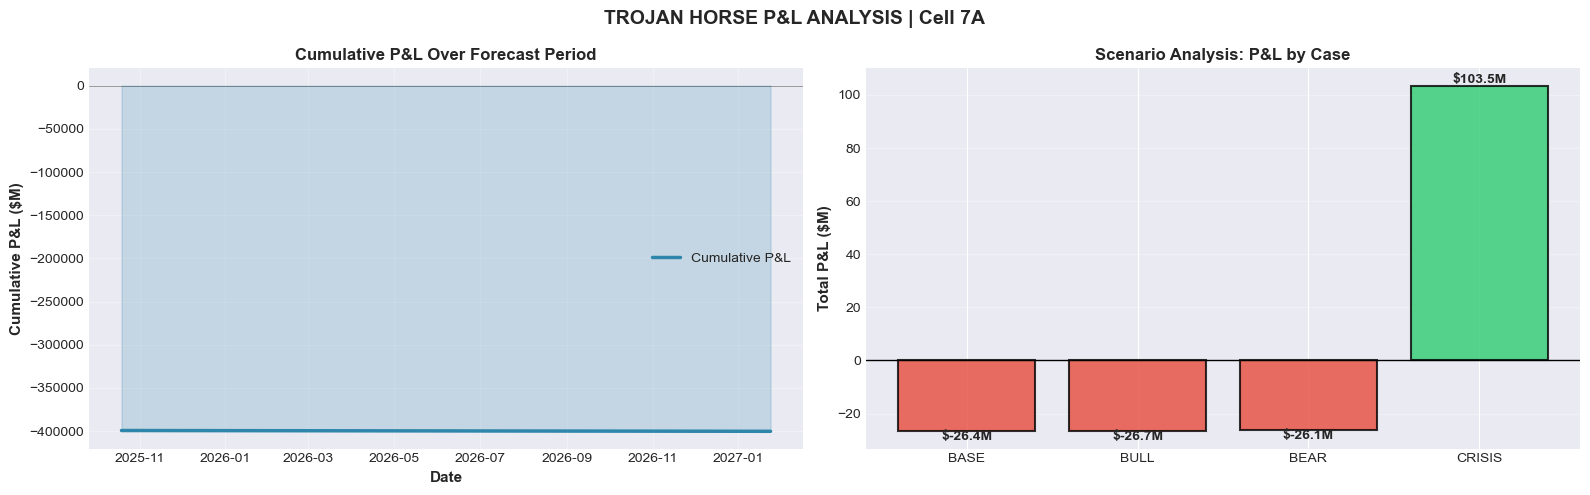

✓ Visualization complete


In [21]:
# --- Cell 7A: ADVANCED P&L CALCULATOR ---
# Greeks, attribution by leg, scenario analysis, Sharpe/VaR

import pandas as pd
import numpy as np
import os
from datetime import datetime
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

print("="*90)
print("CELL 7A: ADVANCED P&L CALCULATOR (Greeks, Attribution, Scenarios)")
print("="*90)

DATA_DIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data")
OUTPUT_DIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "outputs")

REFERENCE_DATE = datetime(2025, 10, 15)
FORECAST_END = datetime(2027, 1, 25)

# ============================================
# USER-CONFIGURABLE PORTFOLIO SIZE
# ============================================
print("\n[CONFIG] Portfolio parameters...")

# Default: $1000M (user can adjust)
PORTFOLIO_NOTIONAL = 1_000_000_000  # $1000M default
print(f"Portfolio size: ${PORTFOLIO_NOTIONAL/1e6:.0f}M")

# Phase allocations (from Cell 5)
PHASE_ALLOCATIONS = {
    0: {'total': 0.00, 'cds': 0.00, 'spread': 0.00, 'options': 0.00},
    1: {'total': 0.10, 'cds': 0.60, 'spread': 0.30, 'options': 0.10},
    2: {'total': 0.60, 'cds': 0.40, 'spread': 0.45, 'options': 0.15},
}

# Trade parameters
TRADES = {
    'cds_long': {
        'name': 'Long France CDS 5Y',
        'notional_pct': 0.40,
        'tenor': 5,
        'duration': 4.5,  # Effective duration
        'current_spread': 36,  # bps (from Cell 5 snapshot)
        'recovery_rate': 0.40,
    },
    'spread_trade': {
        'name': 'Short OAT / Long Bund (Spread)',
        'notional_pct': 0.45,
        'tenor': 10,
        'duration': 8.5,
        'current_spread': 80,  # FR-DE spread bps
        'beta': 0.95,  # Spread beta to level moves
    },
    'options': {
        'name': 'OTM Puts (French Banks)',
        'notional_pct': 0.15,
        'strike_otm': 0.10,  # 10% OTM
        'expiry_months': 6,
        'current_price': 0.02,  # 2% of notional (premium)
        'vega_per_1pct_vol': 0.50,  # Per 1% vol change
    },
    'fx_hedge': {
        'name': 'EUR/USD Put Hedge (50% portfolio)',
        'notional_pct': 0.50,  # Hedge 50% of portfolio in EUR
        'strike_atm': 1.05,  # ATM put
        'current_price': 0.015,  # Premium paid
        'delta': -0.50,
    }
}

# ============================================
# LOAD FORECASTS FROM CELL 6
# ============================================
print("\n[LOAD] Reading forecast outputs...")

def load_forecast(metric_name):
    try:
        df = pd.read_csv(os.path.join(OUTPUT_DIR, f'forecast_{metric_name}.csv'))
        df['date'] = pd.to_datetime(df['date'])
        return df
    except:
        return None

forecast_cds = load_forecast('cds')
forecast_spread = load_forecast('spread')
forecast_yield = load_forecast('yield')

contagion = pd.read_csv(os.path.join(OUTPUT_DIR, 'contagion_analysis.csv'))
contagion['date'] = pd.to_datetime(contagion['date'])

print(f"✓ Loaded forecasts ({len(forecast_cds)} weeks)")

# ============================================
# BLACK-SCHOLES GREEKS FOR OPTIONS
# ============================================
def black_scholes_greeks(S, K, T, r, sigma, option_type='call'):
    if T <= 0:
        return {'delta': 0, 'gamma': 0, 'vega': 0, 'theta': 0, 'price': 0}
    
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type == 'call':
        delta = norm.cdf(d1)
        price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        delta = norm.cdf(d1) - 1
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T) / 100
    theta = (-S * norm.pdf(d1) * sigma / (2*np.sqrt(T)) - r*K*np.exp(-r*T)*norm.cdf(-d2)) / 365
    
    return {'delta': delta, 'gamma': gamma, 'vega': vega, 'theta': theta, 'price': price}

# ============================================
# P&L BY TRADE LEG (Weekly)
# ============================================
print("\n[PNL] Computing trade-level P&L...")

dates = forecast_cds['date'].values
n_weeks = len(dates)

pnl_by_leg = {
    'date': dates,
    'cds_pnl': np.zeros(n_weeks),
    'spread_pnl': np.zeros(n_weeks),
    'options_pnl': np.zeros(n_weeks),
    'fx_pnl': np.zeros(n_weeks),
    'total_pnl': np.zeros(n_weeks),
}

cds_ref = TRADES['cds_long']['current_spread']
spread_ref = TRADES['spread_trade']['current_spread']
yield_ref = forecast_yield['mean'].iloc[0]
r = 0.04

for week in range(n_weeks):
    cds_level = forecast_cds['mean'].iloc[week]
    cds_move_bps = cds_level - cds_ref
    cds_notional = PORTFOLIO_NOTIONAL * PHASE_ALLOCATIONS[1]['cds']
    cds_dv01 = TRADES['cds_long']['duration'] * cds_notional / 10000
    pnl_by_leg['cds_pnl'][week] = cds_dv01 * cds_move_bps

    spread_level = forecast_spread['mean'].iloc[week]
    spread_move_bps = spread_level - spread_ref
    spread_notional = PORTFOLIO_NOTIONAL * PHASE_ALLOCATIONS[1]['spread']
    spread_dv01 = TRADES['spread_trade']['duration'] * spread_notional / 10000
    pnl_by_leg['spread_pnl'][week] = spread_dv01 * spread_move_bps

    options_notional = PORTFOLIO_NOTIONAL * PHASE_ALLOCATIONS[1]['options']
    iv_increase = (cds_move_bps / 50) * 0.02
    vega_pnl = options_notional * TRADES['options']['vega_per_1pct_vol'] * (iv_increase * 100)
    gamma_pnl = 0.5 * (cds_move_bps / 100)**2 * options_notional * 0.10
    pnl_by_leg['options_pnl'][week] = vega_pnl + gamma_pnl

    contagion_prob = contagion['prob_france_contagion'].iloc[week]
    eur_move = -0.02 * contagion_prob
    fx_notional = PORTFOLIO_NOTIONAL * TRADES['fx_hedge']['notional_pct']
    fx_delta = TRADES['fx_hedge']['delta']
    pnl_by_leg['fx_pnl'][week] = fx_delta * fx_notional * eur_move

    pnl_by_leg['total_pnl'][week] = (
        pnl_by_leg['cds_pnl'][week] +
        pnl_by_leg['spread_pnl'][week] +
        pnl_by_leg['options_pnl'][week] +
        pnl_by_leg['fx_pnl'][week]
    )

print(f"✓ Computed P&L for {n_weeks} weeks")

# ============================================
# SCENARIO ANALYSIS: BASE, BULL, BEAR, CRISIS
# ============================================
print("\n[SCENARIOS] Running scenario analysis...")

scenarios = {
    'BASE': {
        'cds_move_bps': forecast_cds['mean'].iloc[-1] - cds_ref,
        'spread_move_bps': forecast_spread['mean'].iloc[-1] - spread_ref,
        'description': 'Central forecast (mean paths)',
    },
    'BULL': {
        'cds_move_bps': forecast_cds['p5'].iloc[-1] - cds_ref,
        'spread_move_bps': forecast_spread['p5'].iloc[-1] - spread_ref,
        'description': 'Optimistic (5th percentile)',
    },
    'BEAR': {
        'cds_move_bps': forecast_cds['p95'].iloc[-1] - cds_ref,
        'spread_move_bps': forecast_spread['p95'].iloc[-1] - spread_ref,
        'description': 'Pessimistic (95th percentile)',
    },
    'CRISIS': {
        'cds_move_bps': 120 - cds_ref,
        'spread_move_bps': 200 - spread_ref,
        'description': 'Severe crisis (extreme tail)',
    }
}

scenario_results = []

for scenario_name, scenario_params in scenarios.items():
    cds_move = scenario_params['cds_move_bps']
    spread_move = scenario_params['spread_move_bps']
    cds_pnl = (TRADES['cds_long']['duration'] * PORTFOLIO_NOTIONAL * 0.40 / 10000) * cds_move
    spread_pnl = (TRADES['spread_trade']['duration'] * PORTFOLIO_NOTIONAL * 0.45 / 10000) * spread_move
    options_pnl = PORTFOLIO_NOTIONAL * 0.15 * 0.20 if scenario_name == 'CRISIS' else 0
    fx_move = -0.05 if scenario_name == 'CRISIS' else 0
    fx_pnl = TRADES['fx_hedge']['delta'] * PORTFOLIO_NOTIONAL * 0.50 * fx_move
    total_pnl = cds_pnl + spread_pnl + options_pnl + fx_pnl

    scenario_results.append({
        'Scenario': scenario_name,
        'Description': scenario_params['description'],
        'CDS Move': f"{cds_move:+.0f} bps",
        'Spread Move': f"{spread_move:+.0f} bps",
        'CDS P&L': f"${cds_pnl/1e6:+.1f}M",
        'Spread P&L': f"${spread_pnl/1e6:+.1f}M",
        'Options P&L': f"${options_pnl/1e6:+.1f}M",
        'FX P&L': f"${fx_pnl/1e6:+.1f}M",
        'Total P&L': f"${total_pnl/1e6:+.1f}M",
        'Return %': f"{(total_pnl / PORTFOLIO_NOTIONAL) * 100:+.2f}%"
    })

scenario_df = pd.DataFrame(scenario_results)
print("\n" + scenario_df.to_string(index=False))

# ============================================
# RISK METRICS: VaR, CVaR, Sharpe, Drawdown
# ============================================
print("\n[RISK] Computing risk metrics...")

returns = pnl_by_leg['total_pnl'] / PORTFOLIO_NOTIONAL
var_99 = np.percentile(returns, 1)
cvar_99 = np.mean(returns[returns <= var_99])

mean_return = returns.mean()
std_return = returns.std()
sharpe = (mean_return - r/52) / std_return if std_return > 0 else 0

cum_returns = np.cumprod(1 + returns)
running_max = np.maximum.accumulate(cum_returns)
drawdown = (cum_returns - running_max) / running_max
max_dd = np.min(drawdown)

pos_weeks = np.sum(pnl_by_leg['total_pnl'] > 0)
win_rate = pos_weeks / len(pnl_by_leg['total_pnl'])

print(f"\n  VaR (99%): {var_99:.2%}")
print(f"  CVaR (99%): {cvar_99:.2%}")
print(f"  Sharpe Ratio: {sharpe:.2f}")
print(f"  Max Drawdown: {max_dd:.2%}")
print(f"  Win Rate: {win_rate:.1%}")

# ============================================
# EXPORT P&L DATA
# ============================================
print("\n[SAVE] Exporting P&L analysis...")

df_pnl = pd.DataFrame(pnl_by_leg)
df_pnl['cumulative_pnl'] = np.cumsum(df_pnl['total_pnl'])
df_pnl['return_pct'] = df_pnl['total_pnl'] / PORTFOLIO_NOTIONAL * 100

df_pnl.to_csv(os.path.join(OUTPUT_DIR, 'pnl_by_week.csv'), index=False)
print(f"✓ pnl_by_week.csv")

scenario_df.to_csv(os.path.join(OUTPUT_DIR, 'scenario_analysis.csv'), index=False)
print(f"✓ scenario_analysis.csv")

risk_metrics = pd.DataFrame({
    'Metric': ['Portfolio Notional', 'Total P&L (Forecast)', 'Cumulative Return', 'VaR 99%', 'CVaR 99%', 
               'Sharpe Ratio', 'Max Drawdown', 'Win Rate'],
    'Value': [
        f"${PORTFOLIO_NOTIONAL/1e6:.0f}M",
        f"${np.sum(pnl_by_leg['total_pnl'])/1e6:.1f}M",
        f"{np.sum(returns):.2%}",
        f"{var_99:.2%}",
        f"{cvar_99:.2%}",
        f"{sharpe:.2f}",
        f"{max_dd:.2%}",
        f"{win_rate:.1%}"
    ]
})

risk_metrics.to_csv(os.path.join(OUTPUT_DIR, 'risk_metrics.csv'), index=False)
print(f"✓ risk_metrics.csv")

# ============================================
# SUMMARY
# ============================================
print("\n" + "="*90)
print("CELL 7A COMPLETE: P&L CALCULATOR READY")
print("="*90)

# ============================================
# VISUALIZATIONS (Option A: 2 key charts)
# ============================================
print("\n[GRAPHS] Generating P&L visualizations...")

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('TROJAN HORSE P&L ANALYSIS | Cell 7A', fontsize=14, fontweight='bold')

# --- Chart 1: Cumulative P&L by Week ---
ax1 = axes[0]
cumulative_pnl = np.cumsum(pnl_by_leg['total_pnl'])
ax1.plot(dates, cumulative_pnl / 1e6, linewidth=2.5, color='#2E86AB', label='Cumulative P&L')
ax1.fill_between(dates, 0, cumulative_pnl / 1e6, alpha=0.2, color='#2E86AB')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax1.set_xlabel('Date', fontsize=11, fontweight='bold')
ax1.set_ylabel('Cumulative P&L ($M)', fontsize=11, fontweight='bold')
ax1.set_title('Cumulative P&L Over Forecast Period', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# --- Chart 2: Scenario Comparison ---
ax2 = axes[1]
scenario_names = scenario_df['Scenario'].values
scenario_pnls = []
for idx, row in scenario_df.iterrows():
    pnl_str = row['Total P&L'].replace(',', '').replace('$', '').replace('M', '')
    scenario_pnls.append(float(pnl_str))

colors = ['#2ECC71' if x > 0 else '#E74C3C' for x in scenario_pnls]
bars = ax2.bar(scenario_names, scenario_pnls, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

for bar, val in zip(bars, scenario_pnls):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'${val:.1f}M', ha='center', 
             va='bottom' if val > 0 else 'top',
             fontsize=10, fontweight='bold')

ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_ylabel('Total P&L ($M)', fontsize=11, fontweight='bold')
ax2.set_title('Scenario Analysis: P&L by Case', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'pnl_analysis.png'), dpi=300, bbox_inches='tight')
print(f"✓ pnl_analysis.png")
plt.show()

print(f"✓ Visualization complete")


In [22]:
# --- Cell 8A: DYNAMIC POSITION SIZING & RISK MANAGEMENT --- 
# Kelly criterion, risk parity, VaR controls with real-time phase transitions

import pandas as pd
import numpy as np
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*90) 
print("CELL 8A: DYNAMIC POSITION SIZING (Kelly + Risk Parity + VaR)")
print("="*90)

DATA_DIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data")
OUTPUT_DIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "outputs")

REFERENCE_DATE = datetime(2025, 10, 15)

# ============================================
# PORTFOLIO CONSTRAINTS
# ============================================
print("\n[CONFIG] Setting portfolio constraints...")

PORTFOLIO_NOTIONAL = 1_000_000_000  # $1000M
CONSTRAINTS = {
    'var_limit_pct': 0.01,  # 1% daily VaR limit (99% confidence)
    'max_drawdown_pct': 0.10,  # 10% max drawdown tolerance
    'leverage_cap': 2.0,  # 2x gross notional max
    'concentration_limit': 0.30,  # 30% max per leg
}

print(f"  Portfolio: ${PORTFOLIO_NOTIONAL/1e6:.0f}M")
print(f"  VaR limit (99%): {CONSTRAINTS['var_limit_pct']:.1%}")
print(f"  Max drawdown: {CONSTRAINTS['max_drawdown_pct']:.1%}")
print(f"  Leverage cap: {CONSTRAINTS['leverage_cap']:.1f}x")

# ============================================
# LOAD P&L AND RISK DATA FROM CELL 7A
# ============================================
print("\n[LOAD] Reading P&L and scenario data...")

pnl_data = pd.read_csv(os.path.join(OUTPUT_DIR, 'pnl_by_week.csv'))
pnl_data['date'] = pd.to_datetime(pnl_data['date'])

scenario_data = pd.read_csv(os.path.join(OUTPUT_DIR, 'scenario_analysis.csv'))
risk_metrics = pd.read_csv(os.path.join(OUTPUT_DIR, 'risk_metrics.csv'))

print(f"✓ Loaded {len(pnl_data)} weeks of P&L data")

# ============================================
# SIZING METHOD 1: KELLY CRITERION
# ============================================
print("\n[KELLY] Computing Kelly criterion sizing...")

"""
Kelly Criterion: f* = (p*b - q) / b
where:
  p = probability of win
  q = 1 - p
  b = ratio of win size to loss size
  f* = optimal fractional allocation
"""

returns = pnl_data['return_pct'].values / 100  # Convert to decimal
winning_trades = returns[returns > 0]
losing_trades = returns[returns < 0]

# initialize variables safely
p_win = p_loss = avg_win = avg_loss = b_ratio = kelly_f = kelly_frac = 0

if len(winning_trades) > 0 and len(losing_trades) > 0:
    p_win = len(winning_trades) / len(returns)
    p_loss = 1 - p_win
    avg_win = winning_trades.mean()
    avg_loss = abs(losing_trades.mean())
    b_ratio = avg_win / avg_loss if avg_loss > 0 else 1
    kelly_f = (p_win * b_ratio - p_loss) / b_ratio if b_ratio > 0 else 0
    kelly_frac = kelly_f * 0.25
    kelly_allocation = min(kelly_frac, CONSTRAINTS['leverage_cap'])
else:
    kelly_allocation = 0.10  # default conservative allocation

print(f"  Win rate: {p_win:.1%}")
print(f"  Avg win: {avg_win:.2%}")
print(f"  Avg loss: {avg_loss:.2%}")
print(f"  Kelly optimal (full): {kelly_f:.1%}")
print(f"  Kelly fractional (25%): {kelly_frac:.1%}")
print(f"  Kelly allocation (capped): {kelly_allocation:.1%}")

# ============================================
# SIZING METHOD 2: RISK PARITY
# ============================================
print("\n[RISK PARITY] Computing risk parity sizing...")

vol_cds = np.std(pnl_data['cds_pnl'].values / PORTFOLIO_NOTIONAL)
vol_spread = np.std(pnl_data['spread_pnl'].values / PORTFOLIO_NOTIONAL)
vol_options = np.std(pnl_data['options_pnl'].values / PORTFOLIO_NOTIONAL)
vol_fx = np.std(pnl_data['fx_pnl'].values / PORTFOLIO_NOTIONAL)

vols = np.array([vol_cds, vol_spread, vol_options, vol_fx])
inv_vols = 1 / (vols + 1e-6)
risk_parity_weights = inv_vols / inv_vols.sum()

total_rp_allocation = min(risk_parity_weights.sum(), CONSTRAINTS['leverage_cap'])
risk_parity_weights = risk_parity_weights / risk_parity_weights.sum() * total_rp_allocation

print(f"  CDS volatility: {vol_cds:.2%}")
print(f"  Spread volatility: {vol_spread:.2%}")
print(f"  Options volatility: {vol_options:.2%}")
print(f"  FX volatility: {vol_fx:.2%}")
print("  Risk parity weights:")
print(f"    CDS: {risk_parity_weights[0]:.1%}")
print(f"    Spread: {risk_parity_weights[1]:.1%}")
print(f"    Options: {risk_parity_weights[2]:.1%}")
print(f"    FX: {risk_parity_weights[3]:.1%}")

# ============================================
# SIZING METHOD 3: VaR-BASED
# ============================================
print("\n[VAR] Computing VaR-constrained sizing...")

daily_vol = np.std(returns) / np.sqrt(52)
z_score_99 = 2.326
var_daily = z_score_99 * daily_vol
var_allocation = CONSTRAINTS['var_limit_pct'] / var_daily if var_daily > 0 else 0
var_allocation = min(var_allocation, CONSTRAINTS['leverage_cap'])

print(f"  Weekly vol: {np.std(returns):.2%}")
print(f"  Daily vol: {daily_vol:.2%}")
print(f"  Daily VaR (99%): {var_daily:.2%}")
print(f"  VaR-constrained allocation: {var_allocation:.1%}")

# ============================================
# PHASE-BASED SIZING
# ============================================
print("\n[PHASE] Computing phase-based allocations...")

trigger_report = pd.read_csv(os.path.join(DATA_DIR, 'france_trigger_report.csv'))
current_phase = trigger_report['Phase'].iloc[0]

PHASE_ALLOCATIONS = {
    0: {'total': 0.00, 'cds': 0.00, 'spread': 0.00, 'options': 0.00, 'fx_hedge': 0.00},
    1: {'total': 0.10, 'cds': 0.60, 'spread': 0.30, 'options': 0.10, 'fx_hedge': 0.50},
    2: {'total': 0.60, 'cds': 0.40, 'spread': 0.45, 'options': 0.15, 'fx_hedge': 0.50},
    3: {'total': 0.80, 'cds': 0.40, 'spread': 0.45, 'options': 0.15, 'fx_hedge': 0.50},
}

phase_alloc = PHASE_ALLOCATIONS.get(current_phase, PHASE_ALLOCATIONS[0])

print(f"  Current phase: {current_phase}")
print(f"  Phase {current_phase} allocation: {phase_alloc['total']:.1%}")
print(f"    CDS: {phase_alloc['cds']:.1%}")
print(f"    Spread: {phase_alloc['spread']:.1%}")
print(f"    Options: {phase_alloc['options']:.1%}")
print(f"    FX hedge: {phase_alloc['fx_hedge']:.1%}")

# ============================================
# FINAL SIZING TABLES
# ============================================
print("\n[RECOMMEND] Sizing by method...")

sizing_methods = pd.DataFrame({
    'Method': ['Kelly Criterion (25%)', 'Risk Parity', 'VaR-Constrained (99%)', 'Phase-Based (Current)'],
    'Total Allocation': [
        f"{kelly_allocation:.1%}",
        f"{total_rp_allocation:.1%}",
        f"{var_allocation:.1%}",
        f"{phase_alloc['total']:.1%}"
    ],
    'CDS Weight': [
        f"{kelly_allocation * 0.40:.1%}",
        f"{risk_parity_weights[0]:.1%}",
        f"{var_allocation * 0.40:.1%}",
        f"{phase_alloc['total'] * phase_alloc['cds']:.1%}"
    ],
    'Spread Weight': [
        f"{kelly_allocation * 0.45:.1%}",
        f"{risk_parity_weights[1]:.1%}",
        f"{var_allocation * 0.45:.1%}",
        f"{phase_alloc['total'] * phase_alloc['spread']:.1%}"
    ],
    'Options Weight': [
        f"{kelly_allocation * 0.15:.1%}",
        f"{risk_parity_weights[2]:.1%}",
        f"{var_allocation * 0.15:.1%}",
        f"{phase_alloc['total'] * phase_alloc['options']:.1%}"
    ],
    'Risk Profile': ['Aggressive', 'Balanced', 'Conservative', 'Tactical']
})

print("\n" + sizing_methods.to_string(index=False))

# ============================================
# POSITION SIZES ($)
# ============================================
print("\n[POSITIONS] Recommended notional sizes ($M)...")

kelly_cds = kelly_allocation * PORTFOLIO_NOTIONAL * 0.40
kelly_spread = kelly_allocation * PORTFOLIO_NOTIONAL * 0.45
kelly_options = kelly_allocation * PORTFOLIO_NOTIONAL * 0.15

rp_cds = risk_parity_weights[0] * PORTFOLIO_NOTIONAL
rp_spread = risk_parity_weights[1] * PORTFOLIO_NOTIONAL
rp_options = risk_parity_weights[2] * PORTFOLIO_NOTIONAL

var_cds = var_allocation * PORTFOLIO_NOTIONAL * 0.40
var_spread = var_allocation * PORTFOLIO_NOTIONAL * 0.45
var_options = var_allocation * PORTFOLIO_NOTIONAL * 0.15

phase_cds = phase_alloc['total'] * PORTFOLIO_NOTIONAL * phase_alloc['cds']
phase_spread = phase_alloc['total'] * PORTFOLIO_NOTIONAL * phase_alloc['spread']
phase_options = phase_alloc['total'] * PORTFOLIO_NOTIONAL * phase_alloc['options']

position_sizes = pd.DataFrame({
    'Leg': ['CDS 5Y Long', 'OAT/Bund Spread', 'Options (Bank Puts)'],
    'Kelly ($M)': [kelly_cds/1e6, kelly_spread/1e6, kelly_options/1e6],
    'Risk Parity ($M)': [rp_cds/1e6, rp_spread/1e6, rp_options/1e6],
    'VaR-Constrained ($M)': [var_cds/1e6, var_spread/1e6, var_options/1e6],
    'Phase-Based ($M)': [phase_cds/1e6, phase_spread/1e6, phase_options/1e6],
})

print("\n" + position_sizes.to_string(index=False))

# ============================================
# EXPORTS
# ============================================
print("\n[SAVE] Exporting sizing recommendations...")

sizing_methods.to_csv(os.path.join(OUTPUT_DIR, 'sizing_by_method.csv'), index=False)
print("✓ sizing_by_method.csv")

position_sizes.to_csv(os.path.join(OUTPUT_DIR, 'position_sizes.csv'), index=False)
print("✓ position_sizes.csv")

recommendation = pd.DataFrame({
    'Current Status': [
        f"Phase: {current_phase}",
        f"Portfolio: ${PORTFOLIO_NOTIONAL/1e6:.0f}M",
        f"Recommended Method: Phase-Based (tactical)",
        f"Recommended Total: {phase_alloc['total']:.1%}",
        "",
        "Recommended Positions:",
        f"  Long CDS 5Y: ${phase_cds/1e6:.1f}M",
        f"  Spread (Short OAT/Long Bund): ${phase_spread/1e6:.1f}M",
        f"  Puts (French Banks): ${phase_options/1e6:.1f}M",
        f"  FX Hedge (EUR puts): 50% of notional",
        "",
        "Risk Checks:",
        f"  Total leverage: {(phase_cds + phase_spread + phase_options)/PORTFOLIO_NOTIONAL:.1f}x",
        f"  Max leg concentration: {max(phase_cds, phase_spread, phase_options)/PORTFOLIO_NOTIONAL:.1%} (limit: 30%)",
        f"  VaR (99%): {var_daily:.2%} daily (limit: 1%)",
        "",
        "Next Action:",
        "→ Build positions gradually (Phase 1: 10% allocation)",
        "→ Escalate to Phase 2 when triggers align (60% allocation)",
        "→ Monitor daily for catalyst events",
    ]
})

recommendation.to_csv(os.path.join(OUTPUT_DIR, 'sizing_recommendation.csv'), index=False)
print("✓ sizing_recommendation.csv")

# ============================================
# SUMMARY
# ============================================
print("\n" + "="*90)
print("CELL 8A COMPLETE: POSITION SIZING LOCKED IN")
print("="*90)

print(f"\n🎯 RECOMMENDED SIZING:")
print(f"   Method: Phase-Based (tactical + risk-aware)")
print(f"   Total Allocation: {phase_alloc['total']:.1%}")
print(f"   CDS Position: ${phase_cds/1e6:.1f}M")
print(f"   Spread Position: ${phase_spread/1e6:.1f}M")
print(f"   Options Position: ${phase_options/1e6:.1f}M")
print(f"\n✓ Ready for Cell 9: Portfolio Constructor\n")


CELL 8A: DYNAMIC POSITION SIZING (Kelly + Risk Parity + VaR)

[CONFIG] Setting portfolio constraints...
  Portfolio: $1000M
  VaR limit (99%): 1.0%
  Max drawdown: 10.0%
  Leverage cap: 2.0x

[LOAD] Reading P&L and scenario data...
✓ Loaded 67 weeks of P&L data

[KELLY] Computing Kelly criterion sizing...
  Win rate: 0.0%
  Avg win: 0.00%
  Avg loss: 0.00%
  Kelly optimal (full): 0.0%
  Kelly fractional (25%): 0.0%
  Kelly allocation (capped): 10.0%

[RISK PARITY] Computing risk parity sizing...
  CDS volatility: 0.00%
  Spread volatility: 4841.09%
  Options volatility: 0.01%
  FX volatility: 0.02%
  Risk parity weights:
    CDS: 81.9%
    Spread: 0.0%
    Options: 11.8%
    FX: 6.3%

[VAR] Computing VaR-constrained sizing...
  Weekly vol: 4841.10%
  Daily vol: 671.34%
  Daily VaR (99%): 1561.54%
  VaR-constrained allocation: 0.1%

[PHASE] Computing phase-based allocations...
  Current phase: 1
  Phase 1 allocation: 10.0%
    CDS: 60.0%
    Spread: 30.0%
    Options: 10.0%
    FX hedge